In [1]:
import json
import pandas as pd

import PySAM
import PySAM.Singleowner as single_owner
import PySAM.Pvsamv1 as pv_model
import PySAM.Grid as grid
import PySAM.Utilityrate5 as utility_rate
import PySAM.ResourceTools as tools

import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns

In [2]:
def get_cmod_json(json_file_path):
    with open(json_file_path) as f:
        dict = json.load(f)
    return dict

In [3]:
configs = []
row_spacing = 16.7
acres = 160.0
while row_spacing < 77:
    configs.append(str(row_spacing) + "ft")
    row_spacing += 5

print(configs)

['16.7ft', '21.7ft', '26.7ft', '31.7ft', '36.7ft', '41.7ft', '46.7ft', '51.7ft', '56.7ft', '61.7ft', '66.7ft', '71.7ft', '76.7ft']


In [4]:
data_folder = "input_json/"
for config in configs:
    so_json = get_cmod_json(data_folder + config + "_singleowner.json")
    print(so_json["total_installed_cost"])

59072704.20727721
47052322.61877187
39017603.15497809
33550652.861423057
29041566.511855125
25978025.446859866
23246588.219407942
21274448.7376651
19282069.2304587
17675913.128093276
16442393.966249766
15283549.83912406
14444170.835497718


In [4]:
# From https://medium.com/@BrendanArtley/matplotlib-color-gradients-21374910584b
def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

In [6]:
adams_df = pd.read_csv("adams_co_data_fine_res.csv")

crop_profits = set(adams_df["Open Air Crop Profit"])
crops = set(adams_df["Crop"])
crops.discard("Open air")
cfg = "16.7ft"
dfs = []
for cfg in configs:
    for cp in crop_profits:
        for crop in crops:
            df_c = adams_df.query('`Open Air Crop Profit` == @cp and NPV > 0 and Config == @cfg and Crop == @crop')
            df_breakeven = df_c.iloc[(df_c["NPV"]).abs().argsort()][:1]
            vals = [cfg, cp, crop, df_breakeven["PPA price"].values[0]]
            dfs.append(df_breakeven)

breakeven_lines = pd.concat(dfs)
cfg_line = breakeven_lines[breakeven_lines.Config == "16.7ft"]


In [15]:
print(breakeven_lines.query('`Config` == "66.7ft"'))
#breakeven_lines.query('`Config` == "66.7ft" or `Config` == "31.7ft"').to_csv("66or31ft_breakeven.csv")
breakeven_lines.to_csv("all_breakeven.csv")

        Unnamed: 0 County        Lat        Long  Config                Crop  \
312833       23783  ADAMS  39.873634 -104.337935  66.7ft               Wheat   
313039       23989  ADAMS  39.873634 -104.337935  66.7ft  Equipment agnostic   
312831       23781  ADAMS  39.873634 -104.337935  66.7ft            Potatoes   
312215       23165  ADAMS  39.873634 -104.337935  66.7ft              Onions   
311807       22757  ADAMS  39.873634 -104.337935  66.7ft         Sugar Beets   
...            ...    ...        ...         ...     ...                 ...   
309093       20043  ADAMS  39.873634 -104.337935  66.7ft               Wheat   
309094       20044  ADAMS  39.873634 -104.337935  66.7ft  Equipment agnostic   
309091       20041  ADAMS  39.873634 -104.337935  66.7ft            Potatoes   
309500       20450  ADAMS  39.873634 -104.337935  66.7ft              Onions   
309707       20657  ADAMS  39.873634 -104.337935  66.7ft         Sugar Beets   

        Solar capacity         CAPEX  P

In [7]:
# ('`Crop Profit` == @cp and NPV > 0 and County == @co_name and Config == @cfg')
us_df = adams_df.query('`Config` == "16.7ft" and `Crop` == "Equipment agnostic"')
us_df = us_df.pivot(index = "PPA price", columns=["Open Air Crop Profit"], values=["NPV"])

sb_df = adams_df.query('`Config` == "31.7ft" and `Crop` == "Equipment agnostic"')
sb_df = sb_df.pivot(index = "PPA price", columns=["Open Air Crop Profit"], values=["NPV"])

ww_df = adams_df.query('`Config` == "66.7ft" and `Crop` == "Equipment agnostic"')
ww_df = ww_df.pivot(index = "PPA price", columns=["Open Air Crop Profit"], values=["NPV"])

In [8]:
us_df.columns.get_level_values(1)

Index([-160000, -152000, -144000, -136000, -128000, -120000, -112000, -104000,
        -96000,  -88000,  -80000,  -72000,  -64000,  -56000,  -48000,  -40000,
        -32000,  -24000,  -16000,   -8000,       0,    8000,   16000,   24000,
         32000,   40000,   48000,   56000,   64000,   72000,   80000,   88000,
         96000,  104000,  112000,  120000,  128000,  136000,  144000,  152000,
        160000],
      dtype='int64', name='Open Air Crop Profit')

In [5]:
SMALL_SIZE = 20
MEDIUM_SIZE = 28
BIGGER_SIZE = 30
        
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [14]:
us_df = adams_df.query('`Config` == "16.7ft" and `Crop` == "Potatoes"')
us_df = us_df.pivot(index = "PPA price", columns=["Open Air Crop Profit"], values=["NPV"])

sb_df = adams_df.query('`Config` == "31.7ft" and `Crop` == "Potatoes"')
sb_df = sb_df.pivot(index = "PPA price", columns=["Open Air Crop Profit"], values=["NPV"])

two_pass_df = adams_df.query('`Config` == "51.7ft" and `Crop` == "Potatoes"')
two_pass_df = two_pass_df.pivot(index = "PPA price", columns=["Open Air Crop Profit"], values=["NPV"])

ww_df = adams_df.query('`Config` == "66.7ft" and `Crop` == "Potatoes"')
ww_df = ww_df.pivot(index = "PPA price", columns=["Open Air Crop Profit"], values=["NPV"])

[ 1000.   950.   900.   850.   800.   750.   700.   650.   600.   550.
   500.   450.   400.   350.   300.   250.   200.   150.   100.    50.
     0.   -50.  -100.  -150.  -200.  -250.  -300.  -350.  -400.  -450.
  -500.  -550.  -600.  -650.  -700.  -750.  -800.  -850.  -900.  -950.
 -1000.]
[0.05   0.05   0.05   0.05   0.0505 0.0505 0.0505 0.0505 0.0505 0.0505
 0.0505 0.0505 0.0505 0.0505 0.0505 0.0505 0.0505 0.0505 0.0505 0.051
 0.051  0.051  0.051  0.051  0.051  0.051  0.051  0.051  0.051  0.051
 0.051  0.051  0.051  0.051  0.051  0.0515 0.0515 0.0515 0.0515 0.0515
 0.0515]


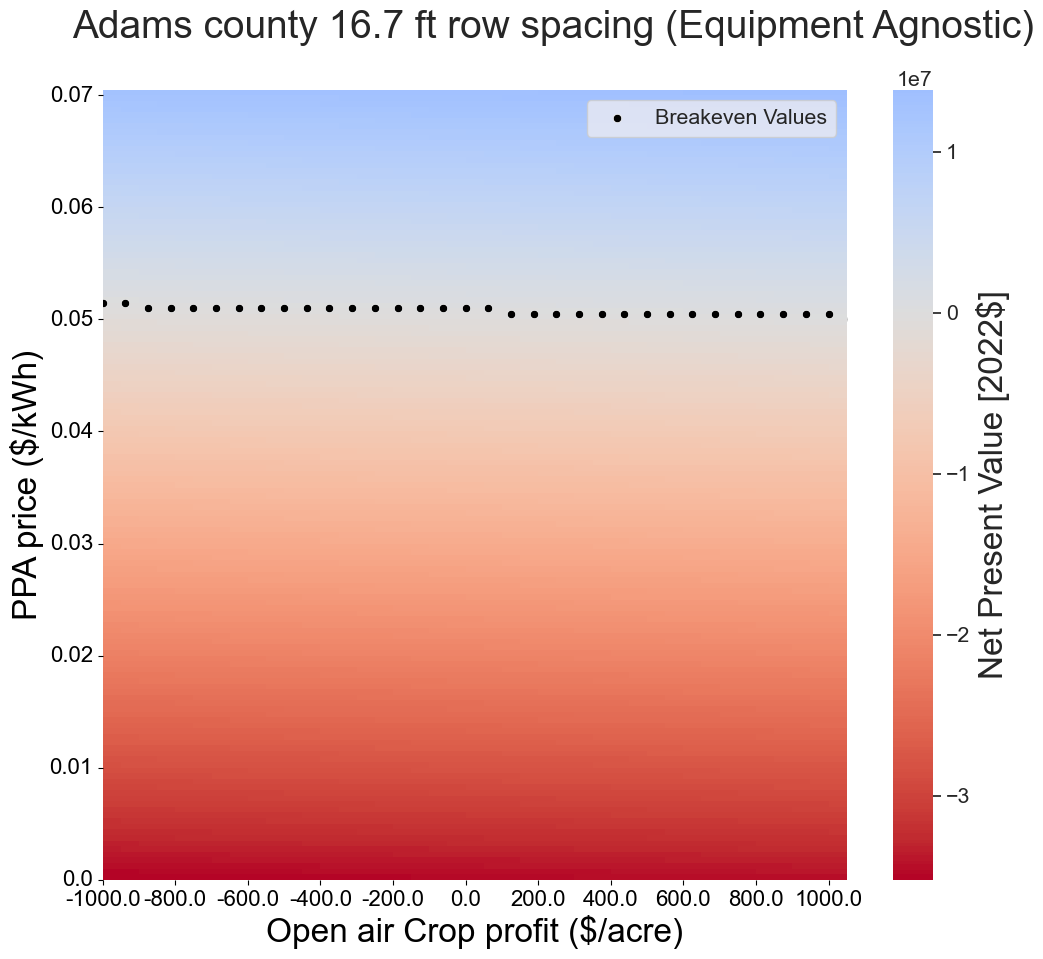

In [19]:
# Plot code courtesy of Heather Mirletz, see https://github.com/NREL/PV_ICE/commits/development/docs/tutorials/13%20-%20LifetimeVsRecycling%20Analysis%20-%20PLOS%20ONE.ipynb for original
us_df = adams_df.query('`Config` == "16.7ft" and `Crop` == "Equipment agnostic"')
us_df = us_df.pivot(index = "PPA price", columns=["Open Air Crop Profit"], values=["NPV"])

values = np.unique(us_df.values.ravel())

#plt.style.use("seaborn")

plt.rcParams['figure.figsize'] = (12, 10)
fig,ax = plt.subplots(1, 1)

xtics = range(0, 41, 4)
xlabels = us_df.columns.get_level_values(1)[0::4] / acres

#ytics = range(0, 35, 5)
#ylabels = us_df.index.values[0::5]
ytics = range(0, 141, 20)
ylabels = us_df.index.values[0::20]

colormax = np.min(us_df.values).min()
colormin = np.max(us_df.values).max()

# Utility scale
sns.set(font_scale = 1.4)
ax = sns.heatmap(us_df.values, annot = False, 
            cmap="coolwarm_r", #sns.diverging_palette(220, 20, n=200), 
            vmin= colormax,
            vmax= colormin,  
            center = 0.0 , #fix to be dynamic finding pvice value
            cbar_kws={'label': 'Net Present Value [2022$]'})

ax.invert_yaxis()

cfg = "16.7ft"
crop = "Equipment agnostic"

cfg_line = breakeven_lines.query('`Config` == @cfg and `Crop` == @crop') 
cfg_line = cfg_line.iloc[(-1.0*cfg_line["Open Air Crop Profit"]).argsort()[:]]
print(cfg_line["Open Air Crop Profit"].values / acres)
print(cfg_line["PPA price"].values)
sns.scatterplot(x=cfg_line["Open Air Crop Profit"].values / acres / 40 + 20, y=cfg_line["PPA price"].values * 2000, label="Breakeven Values", color='black')



plt.suptitle('Adams county 16.7 ft row spacing (Equipment Agnostic)', fontsize = 28)

plt.xlabel('Open air Crop profit ($/acre)', fontsize = 24)
plt.ylabel('PPA price ($/kWh)', fontsize = 24)


plt.xticks(ticks=xtics, labels=xlabels, rotation=0, fontsize = 16)
plt.yticks(ticks=ytics, labels=ylabels, fontsize = 16)
ax.figure.axes[-1].yaxis.label.set_size(24)


plt.subplots_adjust(top=0.9)
#fig.tight_layout(h_pad=2)

plt.savefig('heatmap-adams-co-16.7-equipment-agnostic.png')


[ 1000.   950.   900.   850.   800.   750.   700.   650.   600.   550.
   500.   450.   400.   350.   300.   250.   200.   150.   100.    50.
     0.   -50.  -100.  -150.  -200.  -250.  -300.  -350.  -400.  -450.
  -500.  -550.  -600.  -650.  -700.  -750.  -800.  -850.  -900.  -950.
 -1000.]
[0.051 0.051 0.051 0.051 0.051 0.051 0.051 0.051 0.051 0.051 0.051 0.051
 0.051 0.051 0.051 0.051 0.051 0.051 0.051 0.051 0.051 0.051 0.051 0.051
 0.051 0.051 0.051 0.051 0.051 0.051 0.051 0.051 0.051 0.051 0.051 0.051
 0.051 0.051 0.051 0.051 0.051]


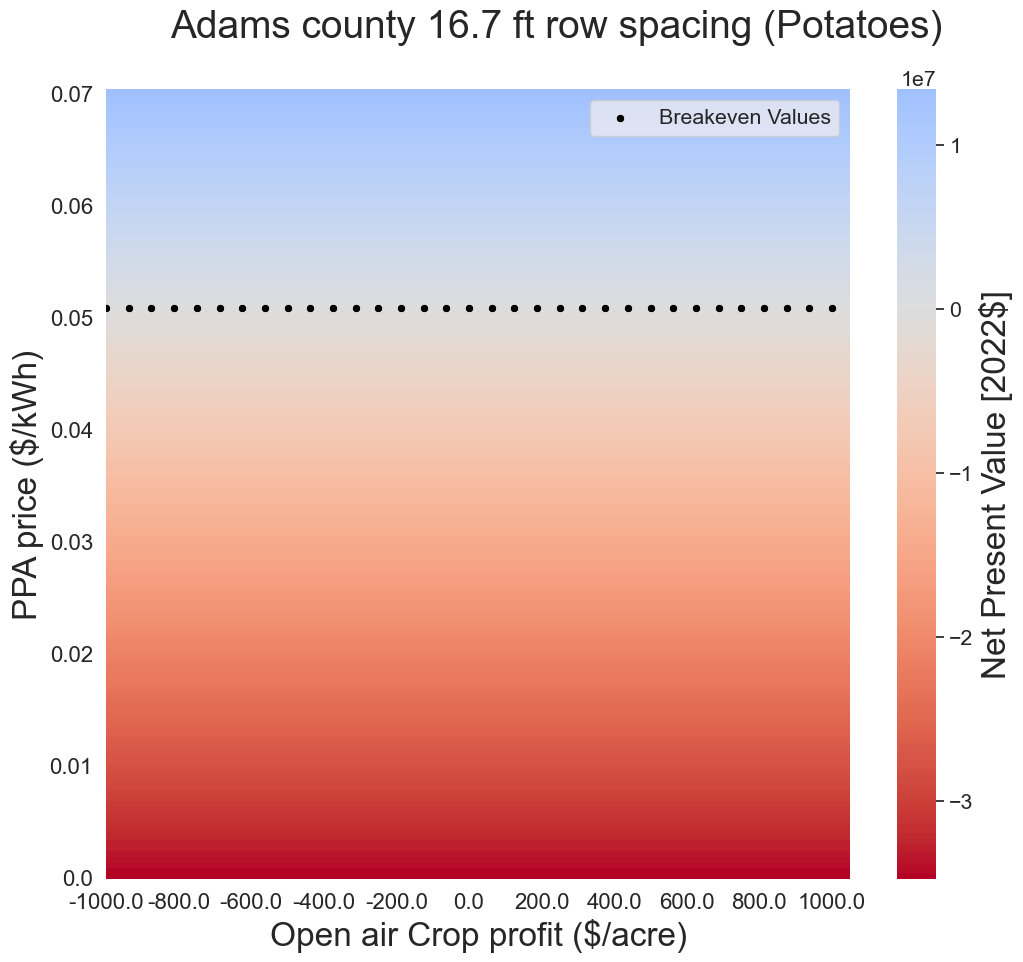

In [49]:
# Plot code courtesy of Heather Mirletz, see https://github.com/NREL/PV_ICE/commits/development/docs/tutorials/13%20-%20LifetimeVsRecycling%20Analysis%20-%20PLOS%20ONE.ipynb for original
us_df = adams_df.query('`Config` == "16.7ft" and `Crop` == "Potatoes"')
us_df = us_df.pivot(index = "PPA price", columns=["Open Air Crop Profit"], values=["NPV"])

values = np.unique(us_df.values.ravel())

#plt.style.use("seaborn")

plt.rcParams['figure.figsize'] = (12, 10)
fig,ax = plt.subplots(1, 1)

xtics = range(0, 41, 4)
xlabels = us_df.columns.get_level_values(1)[0::4] / acres

#ytics = range(0, 35, 5)
#ylabels = us_df.index.values[0::5]
ytics = range(0, 141, 20)
ylabels = us_df.index.values[0::20]

colormax = np.min(us_df.values).min()
colormin = np.max(us_df.values).max()

# Utility scale
sns.set(font_scale = 1.4)
ax = sns.heatmap(us_df.values, annot = False, 
            cmap="coolwarm_r", #sns.diverging_palette(220, 20, n=200), 
            vmin= colormax,
            vmax= colormin,  
            center = 0.0 , #fix to be dynamic finding pvice value
            cbar_kws={'label': 'Net Present Value [2022$]'})

ax.invert_yaxis()

cfg = "16.7ft"
crop = "Potatoes"

cfg_line = breakeven_lines.query('`Config` == @cfg and `Crop` == @crop') 
cfg_line = cfg_line.iloc[(-1.0*cfg_line["Open Air Crop Profit"]).argsort()[:]]
print(cfg_line["Open Air Crop Profit"].values / acres)
print(cfg_line["PPA price"].values)
sns.scatterplot(x=cfg_line["Open Air Crop Profit"].values / acres / 40 + 20, y=cfg_line["PPA price"].values * 2000, label="Breakeven Values", color='black')



plt.suptitle('Adams county 16.7 ft row spacing (Potatoes)', fontsize = 28)

plt.xlabel('Open air Crop profit ($/acre)', fontsize = 24)
plt.ylabel('PPA price ($/kWh)', fontsize = 24)


plt.xticks(ticks=xtics, labels=xlabels, rotation=0, fontsize = 16)
plt.yticks(ticks=ytics, labels=ylabels, fontsize = 16)
ax.figure.axes[-1].yaxis.label.set_size(24)


plt.subplots_adjust(top=0.9)
#fig.tight_layout(h_pad=2)

plt.savefig('heatmap-adams-co-16.7-potatoes.png')


[ 1000.   950.   900.   850.   800.   750.   700.   650.   600.   550.
   500.   450.   400.   350.   300.   250.   200.   150.   100.    50.
     0.   -50.  -100.  -150.  -200.  -250.  -300.  -350.  -400.  -450.
  -500.  -550.  -600.  -650.  -700.  -750.  -800.  -850.  -900.  -950.
 -1000.]
[0.0485 0.0485 0.049  0.049  0.049  0.049  0.049  0.0495 0.0495 0.0495
 0.0495 0.0495 0.05   0.05   0.05   0.05   0.0505 0.0505 0.0505 0.0505
 0.0505 0.051  0.051  0.051  0.051  0.051  0.0515 0.0515 0.0515 0.0515
 0.052  0.052  0.052  0.052  0.052  0.0525 0.0525 0.0525 0.0525 0.0525
 0.053 ]


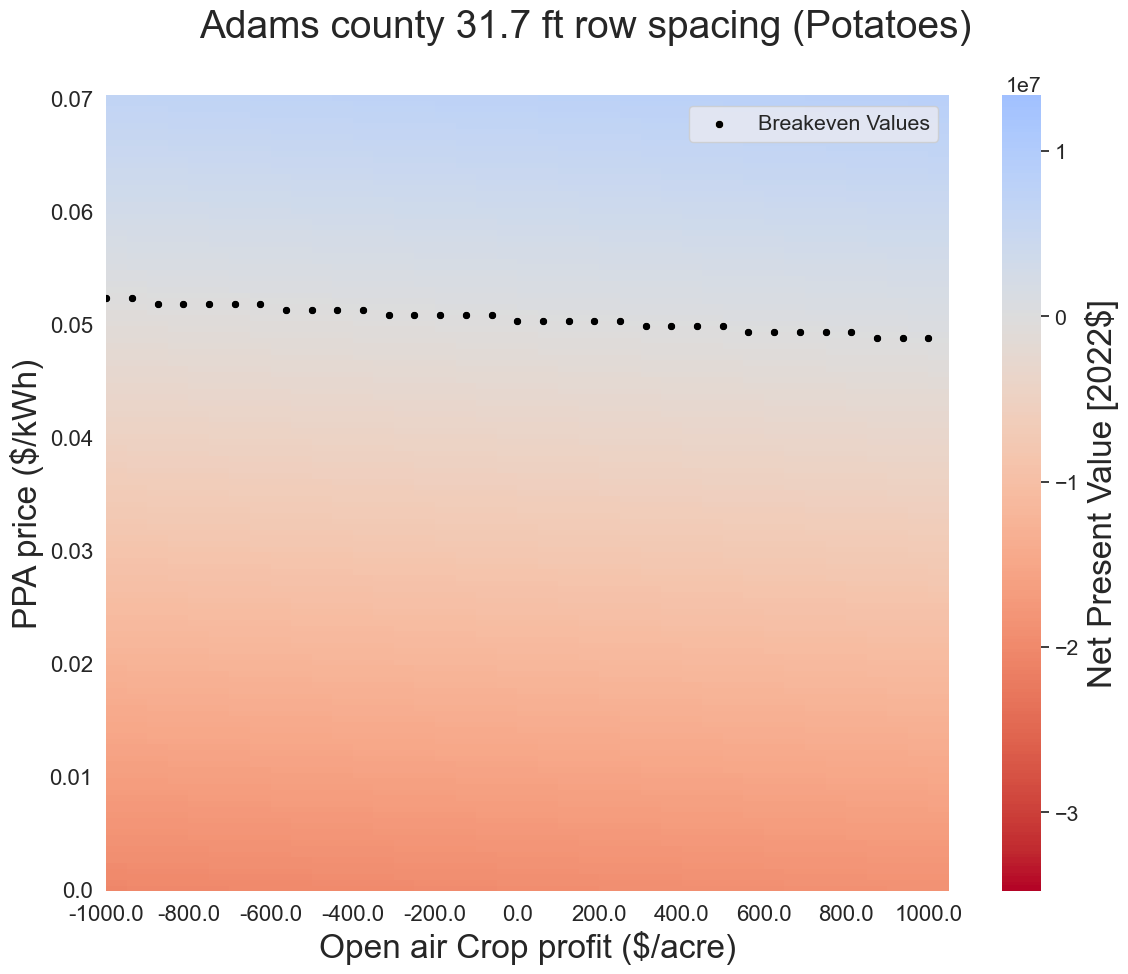

In [55]:

# Sugar beets
#plt.style.use("seaborn")

plt.rcParams['figure.figsize'] = (12, 10)
fig,ax = plt.subplots(1, 1)
sns.set(font_scale = 1.4)
ax = sns.heatmap(sb_df.values, annot = False, 
            cmap='coolwarm_r', #sns.diverging_palette(220, 20, n=200), 
            vmin= colormax,
            vmax= colormin, 
            center = 0.0 , #fix to be dynamic finding pvice value
            cbar_kws={'label': 'Net Present Value [2022$]'})
ax.invert_yaxis()
plt.suptitle('Adams county 31.7 ft row spacing (Potatoes)', fontsize = 28)

cfg = "31.7ft"
crop = "Potatoes"

cfg_line = breakeven_lines.query('`Config` == @cfg and `Crop` == @crop') 
cfg_line = cfg_line.iloc[(-1.0*cfg_line["Open Air Crop Profit"]).argsort()[:]]
print(cfg_line["Open Air Crop Profit"].values / acres)
print(cfg_line["PPA price"].values)
sns.scatterplot(x=cfg_line["Open Air Crop Profit"].values / acres / 40 + 20, y=cfg_line["PPA price"].values * 2000, label="Breakeven Values", color='black')


plt.xlabel('Open air Crop profit ($/acre)', fontsize = 24)
plt.ylabel('PPA price ($/kWh)', fontsize = 24)


plt.xticks(ticks=xtics, labels=xlabels, rotation=0, fontsize = 16)
plt.yticks(ticks=ytics, labels=ylabels, fontsize = 16)
ax.figure.axes[-1].yaxis.label.set_size(24)

plt.subplots_adjust(top=0.9)
fig.tight_layout(h_pad=1)

plt.savefig('heatmap-adams-co-31.7-potatoes.png')


[ 1000.   950.   900.   850.   800.   750.   700.   650.   600.   550.
   500.   450.   400.   350.   300.   250.   200.   150.   100.    50.
     0.   -50.  -100.  -150.  -200.  -250.  -300.  -350.  -400.  -450.
  -500.  -550.  -600.  -650.  -700.  -750.  -800.  -850.  -900.  -950.
 -1000.]
[0.047  0.0475 0.0475 0.048  0.048  0.0485 0.0485 0.0485 0.049  0.049
 0.0495 0.0495 0.0495 0.05   0.05   0.0505 0.0505 0.051  0.051  0.051
 0.0515 0.0515 0.052  0.052  0.0525 0.0525 0.0525 0.053  0.053  0.0535
 0.0535 0.0535 0.054  0.054  0.0545 0.0545 0.055  0.055  0.055  0.0555
 0.0555]


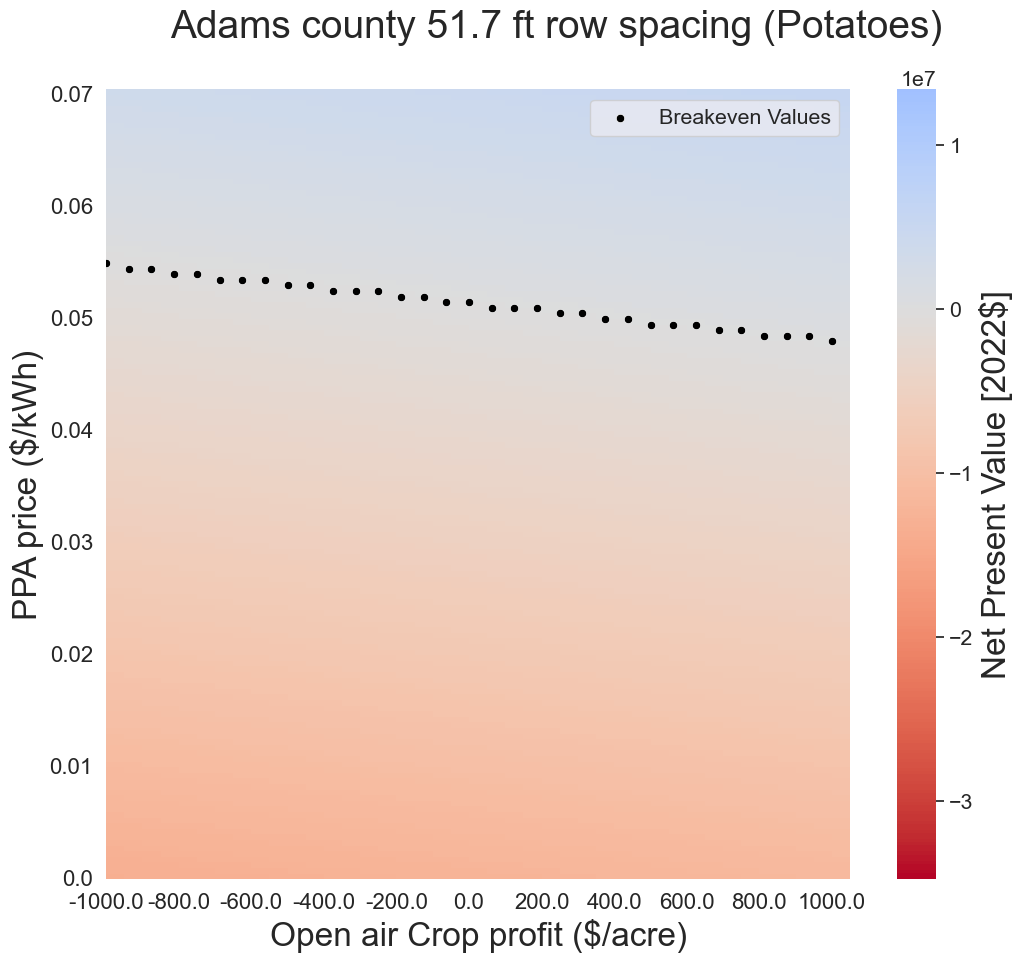

In [54]:

# Plot code courtesy of Heather Mirletz, see https://github.com/NREL/PV_ICE/commits/development/docs/tutorials/13%20-%20LifetimeVsRecycling%20Analysis%20-%20PLOS%20ONE.ipynb for original

values = np.unique(us_df.values.ravel())

#plt.style.use("seaborn")

plt.rcParams['figure.figsize'] = (12, 10)
fig,ax = plt.subplots(1, 1)

xtics = range(0, 41, 4)
xlabels = two_pass_df.columns.get_level_values(1)[0::4] / acres

#ytics = range(0, 35, 5)
#ylabels = us_df.index.values[0::5]
ytics = range(0, 141, 20)
ylabels = two_pass_df.index.values[0::20]

colormax = np.min(us_df.values).min()
colormin = np.max(us_df.values).max()

# Utility scale
sns.set(font_scale = 1.4)
ax = sns.heatmap(two_pass_df.values, annot = False, 
            cmap="coolwarm_r", #sns.diverging_palette(220, 20, n=200), 
            vmin= colormax,
            vmax= colormin,  
            center = 0.0 , #fix to be dynamic finding pvice value
            cbar_kws={'label': 'Net Present Value [2022$]'})
ax.invert_yaxis()
plt.suptitle('Adams county 51.7 ft row spacing (Potatoes)', fontsize = 28)

cfg = "51.7ft"
crop = "Potatoes"

cfg_line = breakeven_lines.query('`Config` == @cfg and `Crop` == @crop') 
cfg_line = cfg_line.iloc[(-1.0*cfg_line["Open Air Crop Profit"]).argsort()[:]]
print(cfg_line["Open Air Crop Profit"].values / acres)
print(cfg_line["PPA price"].values)
sns.scatterplot(x=cfg_line["Open Air Crop Profit"].values / acres / 40 + 20, y=cfg_line["PPA price"].values * 2000, label="Breakeven Values", color='black')


plt.xlabel('Open air Crop profit ($/acre)', fontsize = 24)
plt.ylabel('PPA price ($/kWh)', fontsize = 24)


plt.xticks(ticks=xtics, labels=xlabels, rotation=0, fontsize = 16)
plt.yticks(ticks=ytics, labels=ylabels, fontsize = 16)
ax.figure.axes[-1].yaxis.label.set_size(24)


plt.subplots_adjust(top=0.9)
#fig.tight_layout(h_pad=2)

plt.savefig('heatmap-adams-co-51.7-potatoes.png')

[ 1000.   950.   900.   850.   800.   750.   700.   650.   600.   550.
   500.   450.   400.   350.   300.   250.   200.   150.   100.    50.
     0.   -50.  -100.  -150.  -200.  -250.  -300.  -350.  -400.  -450.
  -500.  -550.  -600.  -650.  -700.  -750.  -800.  -850.  -900.  -950.
 -1000.]
[0.0455 0.046  0.046  0.0465 0.047  0.047  0.0475 0.048  0.048  0.0485
 0.0485 0.049  0.0495 0.0495 0.05   0.0505 0.0505 0.051  0.051  0.0515
 0.052  0.052  0.0525 0.053  0.053  0.0535 0.054  0.054  0.0545 0.0545
 0.055  0.0555 0.0555 0.056  0.0565 0.0565 0.057  0.057  0.0575 0.058
 0.058 ]


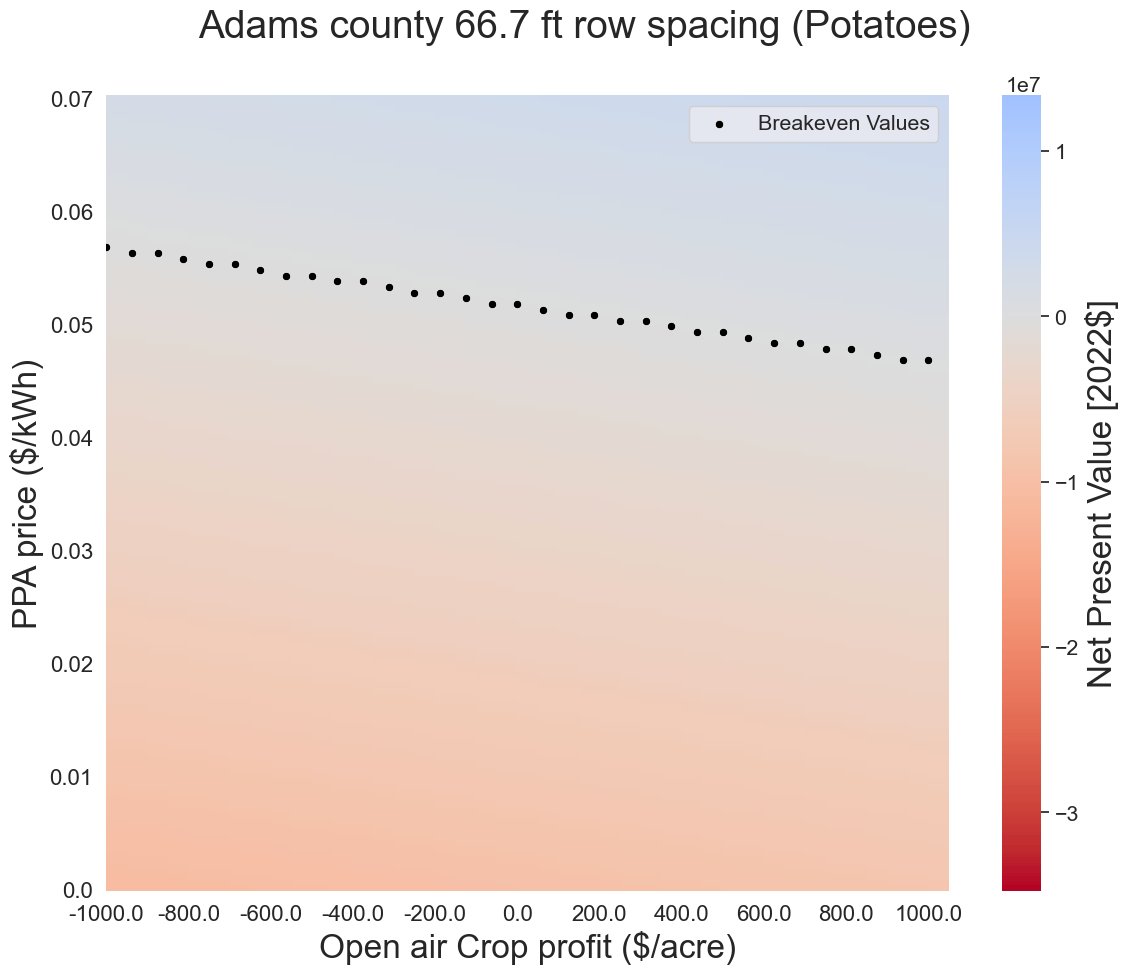

In [53]:
# Winter wheat

#plt.style.use("seaborn")

plt.rcParams['figure.figsize'] = (12, 10)
fig,ax = plt.subplots(1, 1)
sns.set(font_scale = 1.4)
ax = sns.heatmap(ww_df.values, annot = False, 
            cmap='coolwarm_r', #sns.diverging_palette(220, 20, n=200), 
            vmin= colormax,
            vmax= colormin, 
            center = 0.0 , #fix to be dynamic finding pvice value
            cbar_kws={'label': 'Net Present Value [2022$]'})
ax.invert_yaxis()
plt.suptitle('Adams county 66.7 ft row spacing (Potatoes)', fontsize = 28)

cfg = "66.7ft"
crop = "Potatoes"

cfg_line = breakeven_lines.query('`Config` == @cfg and `Crop` == @crop') 
cfg_line = cfg_line.iloc[(-1.0*cfg_line["Open Air Crop Profit"]).argsort()[:]]
print(cfg_line["Open Air Crop Profit"].values / acres)
print(cfg_line["PPA price"].values)
sns.scatterplot(x=cfg_line["Open Air Crop Profit"].values / acres / 40 + 20, y=cfg_line["PPA price"].values * 2000, label="Breakeven Values", color='black')


plt.xlabel('Open air Crop profit ($/acre)', fontsize = 24)
plt.ylabel('PPA price ($/kWh)', fontsize = 24)


plt.xticks(ticks=xtics, labels=xlabels, rotation=0, fontsize = 16)
plt.yticks(ticks=ytics, labels=ylabels, fontsize = 16)
ax.figure.axes[-1].yaxis.label.set_size(24)

plt.subplots_adjust(top=0.9)
fig.tight_layout(h_pad=1)

plt.savefig('heatmap-adams-co-66.7-potatoes.png')
plt.show()


In [22]:
df = pd.read_csv("co_counties_multi_crop_data.csv")

In [23]:
df_c = df.query('`Crop Profit` == 15000 and NPV > 0 and County == "RIO BLANCO" and Config == "16.7ft"')
df_breakeven = df_c.iloc[(df_c["NPV"]).abs().argsort()][:1]
print(df_breakeven)

UndefinedVariableError: name 'BACKTICK_QUOTED_STRING_Crop_Profit' is not defined

In [24]:
counties = set(df["County"])
crop_profit = set(df["Open Air Crop Profit"])
configs = set(df["Config"])
crops = set(df['Crop'])
bkevn_dfs = []
jobs = itertools.product(counties, crop_profit, configs, crops)
for job in jobs:
    co_name = job[0]
    cfg = str(job[2])
    cp = job[1]
    crp = job[3]
    print(co_name, cfg, cp, crp)
    df_c = df.query('`Open Air Crop Profit` == @cp and NPV > 0 and County == @co_name and Config == @cfg and Crop == @crp')
    print(len(df_c))
    df_breakeven = df_c.iloc[(df_c["NPV"]).abs().argsort()][:1]
    bkevn_dfs.append(df_breakeven)

results = pd.concat(bkevn_dfs)

RIO GRANDE 31.7ft 24000 Potatoes
56
RIO GRANDE 31.7ft 24000 Equipment agnostic
56
RIO GRANDE 31.7ft 24000 Onions
56
RIO GRANDE 31.7ft 24000 Sugar Beets
56
RIO GRANDE 31.7ft 24000 Wheat
56
RIO GRANDE 66.7ft 24000 Potatoes
53
RIO GRANDE 66.7ft 24000 Equipment agnostic
54
RIO GRANDE 66.7ft 24000 Onions
53
RIO GRANDE 66.7ft 24000 Sugar Beets
53
RIO GRANDE 66.7ft 24000 Wheat
53
RIO GRANDE 31.7ft 80000 Potatoes
57
RIO GRANDE 31.7ft 80000 Equipment agnostic
58
RIO GRANDE 31.7ft 80000 Onions
58
RIO GRANDE 31.7ft 80000 Sugar Beets
56
RIO GRANDE 31.7ft 80000 Wheat
56
RIO GRANDE 66.7ft 80000 Potatoes
57
RIO GRANDE 66.7ft 80000 Equipment agnostic
58
RIO GRANDE 66.7ft 80000 Onions
56
RIO GRANDE 66.7ft 80000 Sugar Beets
55
RIO GRANDE 66.7ft 80000 Wheat
57
BACA 31.7ft 24000 Potatoes
49
BACA 31.7ft 24000 Equipment agnostic
50
BACA 31.7ft 24000 Onions
50
BACA 31.7ft 24000 Sugar Beets
49
BACA 31.7ft 24000 Wheat
49
BACA 66.7ft 24000 Potatoes
46
BACA 66.7ft 24000 Equipment agnostic
46
BACA 66.7ft 24000 On

In [26]:
results.to_csv("co_counties_breakeven_prices.csv")

In [11]:
adams_df = pd.read_csv("adams_co_data_fine_res.csv")

[0.0415 0.0415 0.0405 0.0415 0.0415 0.0415 0.0415 0.0415 0.0405 0.0415
 0.0415 0.0415 0.0405 0.0415 0.0415 0.0415 0.0415 0.0415 0.041  0.0415
 0.0415 0.041  0.0415 0.0415 0.0415 0.0415 0.0415 0.0415 0.0415 0.041
 0.0415 0.0415 0.041  0.0415 0.0415 0.0415 0.0415 0.0415 0.041  0.0415
 0.0415 0.0415 0.0415 0.041  0.0415 0.0415 0.0415 0.0415 0.041  0.0415
 0.0415 0.0415 0.0415 0.041  0.0415 0.0415 0.041  0.0415 0.0415 0.0415
 0.0415 0.0415 0.0415 0.041  0.0415 0.0415 0.0415 0.041  0.0415 0.0415
 0.041  0.0415 0.0415 0.0415 0.0415 0.0415 0.041  0.0415 0.0415 0.0415
 0.0415 0.041  0.0415 0.0415 0.0415 0.041  0.0415 0.0415 0.0415 0.0415
 0.0415 0.0415 0.0415 0.0415 0.0415 0.0415 0.0415 0.0415 0.0415 0.0415
 0.0415 0.0415 0.0415 0.0415 0.0415 0.0415 0.0415 0.0415 0.0415 0.0415
 0.0415 0.0415 0.0415 0.0415 0.0415 0.0415 0.0415 0.0415 0.0415 0.0415
 0.0415 0.0415 0.0415 0.0415 0.0415 0.0415 0.0415 0.0415 0.0415 0.0415
 0.0415 0.0415 0.0415 0.0415 0.0415 0.0415 0.0415 0.0415 0.0415 0.0415
 0.0415

[<matplotlib.collections.PathCollection object at 0x0000020DE0B97290>, <matplotlib.collections.PathCollection object at 0x0000020DE0C21C50>, <matplotlib.collections.PathCollection object at 0x0000020DE0C27A10>, <matplotlib.collections.PathCollection object at 0x0000020DE0C222D0>, <matplotlib.collections.PathCollection object at 0x0000020DE0C287D0>, <matplotlib.collections.PathCollection object at 0x0000020DE0C2F810>, <matplotlib.collections.PathCollection object at 0x0000020DE0C207D0>, <matplotlib.collections.PathCollection object at 0x0000020DE0C33750>, <matplotlib.collections.PathCollection object at 0x0000020DDF2B3350>, <matplotlib.collections.PathCollection object at 0x0000020DE0C34F90>, <matplotlib.collections.PathCollection object at 0x0000020DE0C39DD0>, <matplotlib.collections.PathCollection object at 0x0000020DE0C3D410>, <matplotlib.collections.PathCollection object at 0x0000020DE0C35A90>]
[<matplotlib.collections.PathCollection object at 0x0000020DE0E99510>, <matplotlib.collec

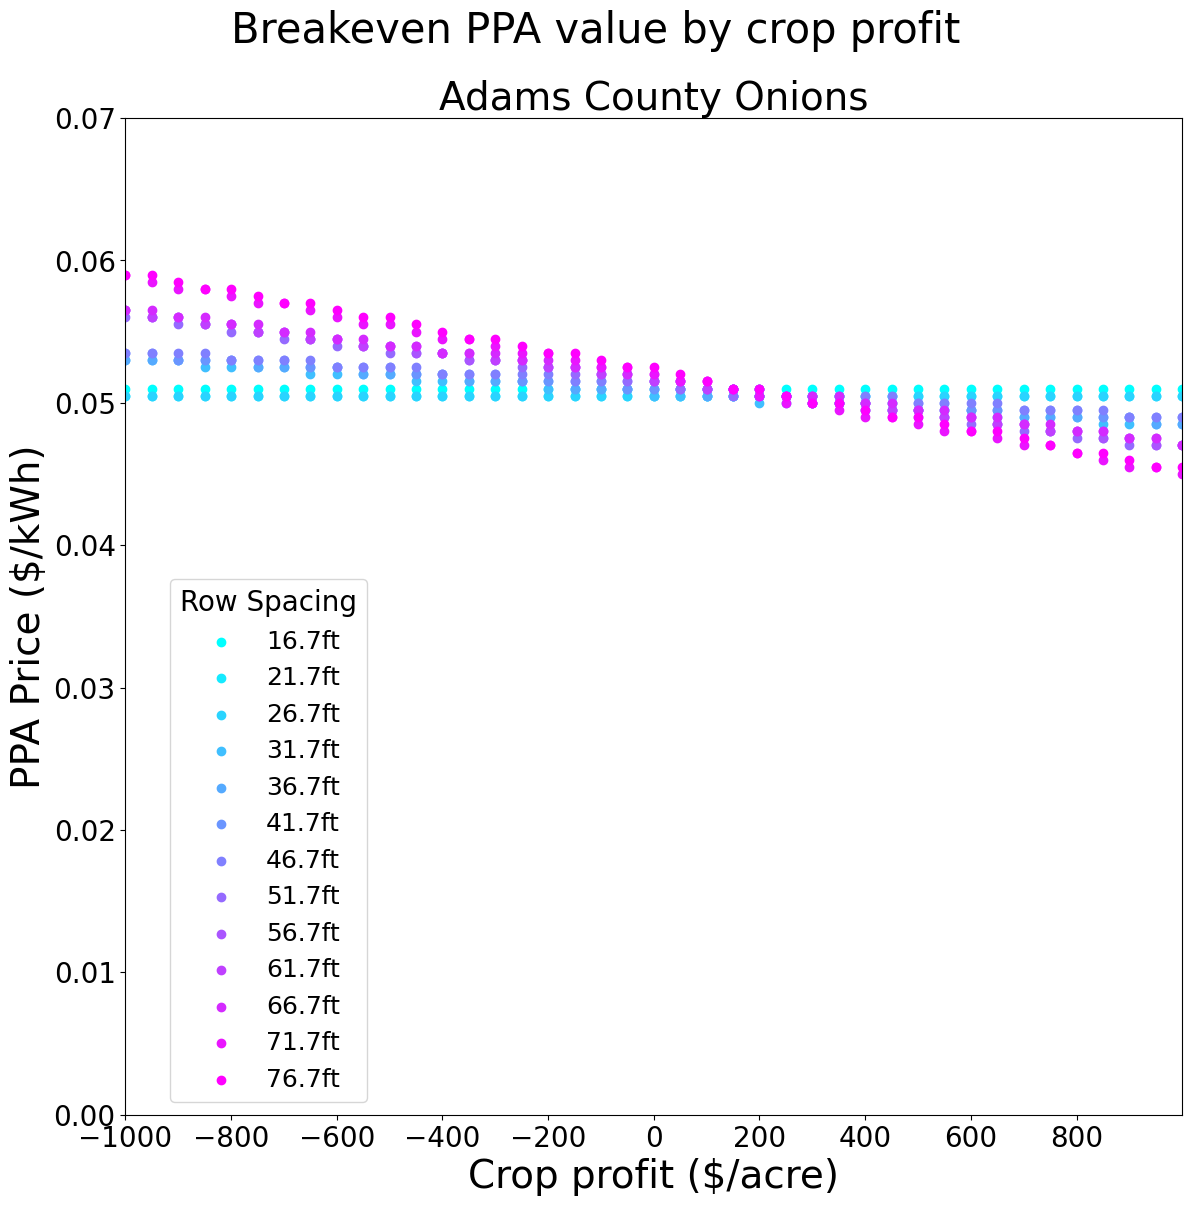

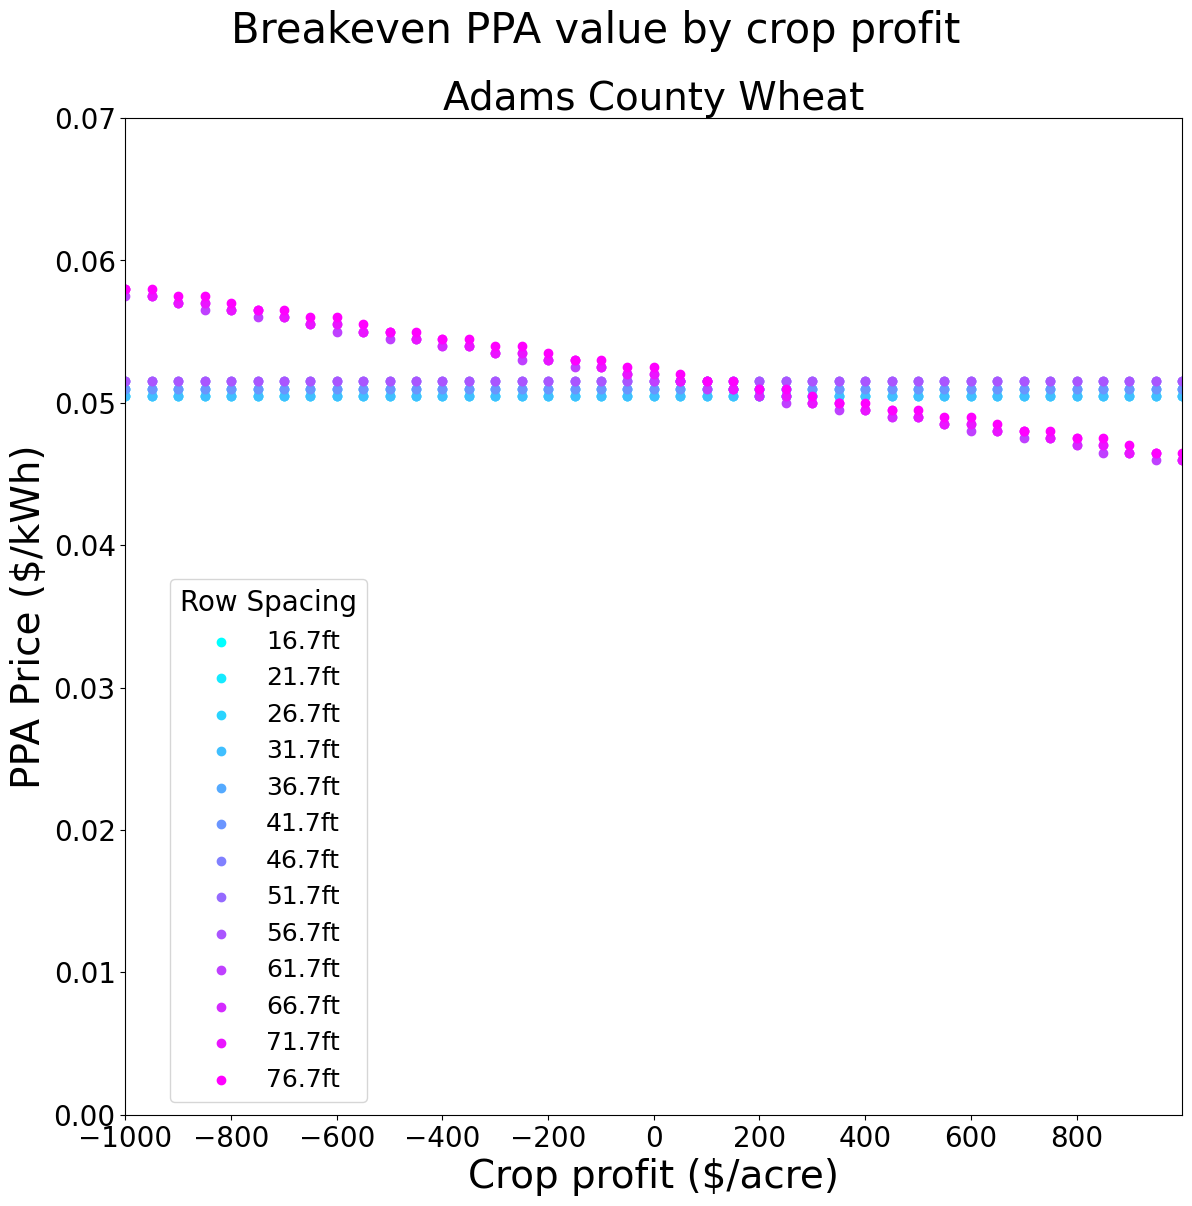

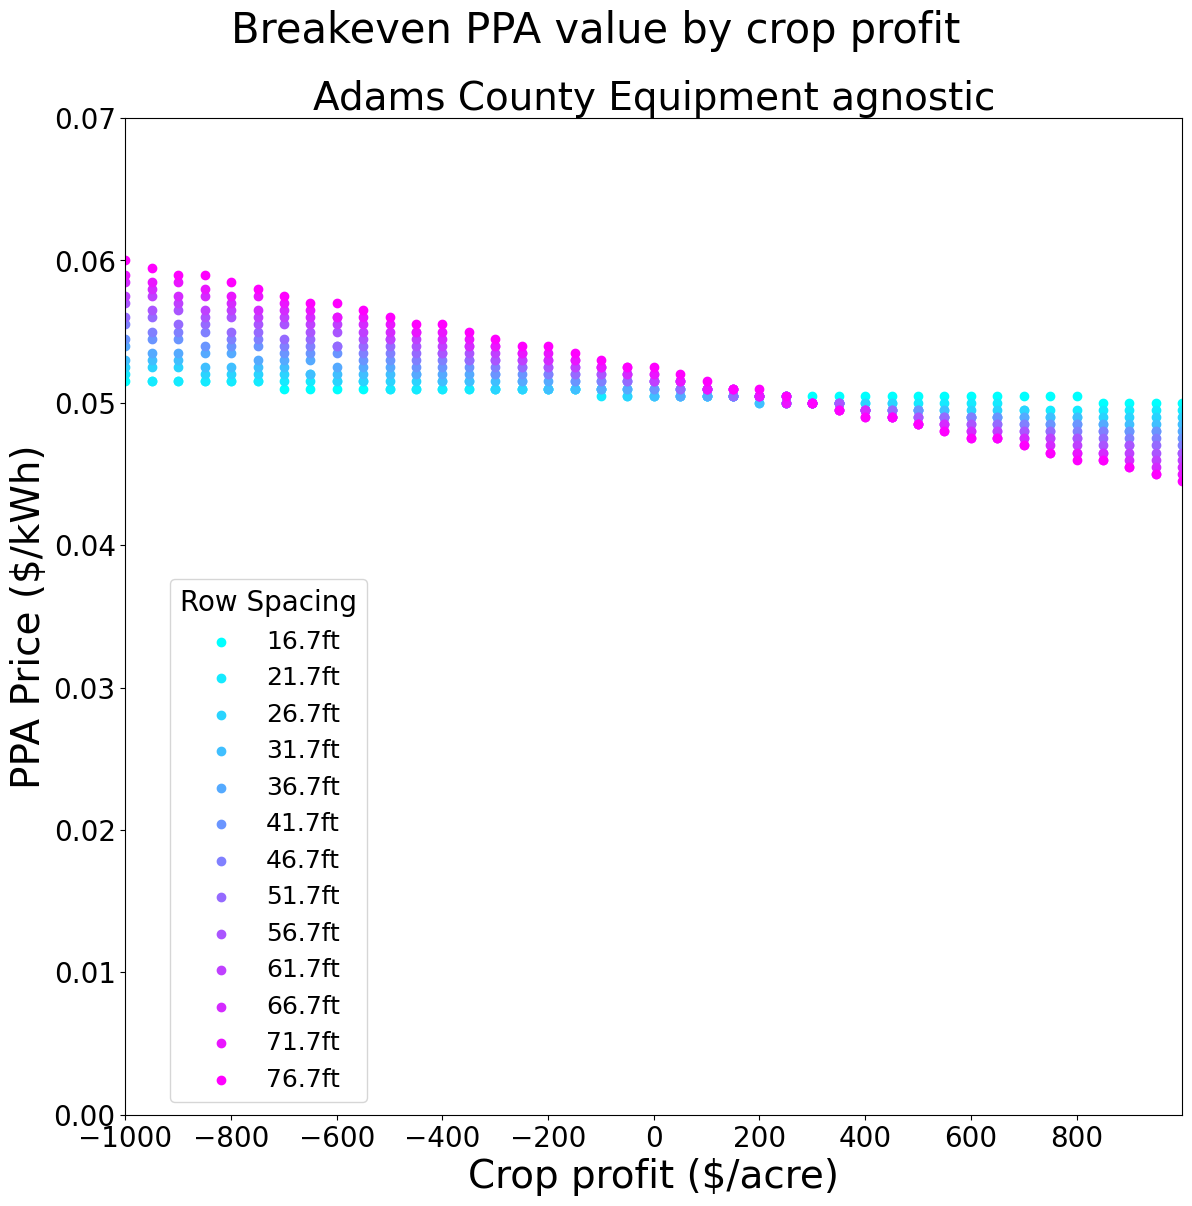

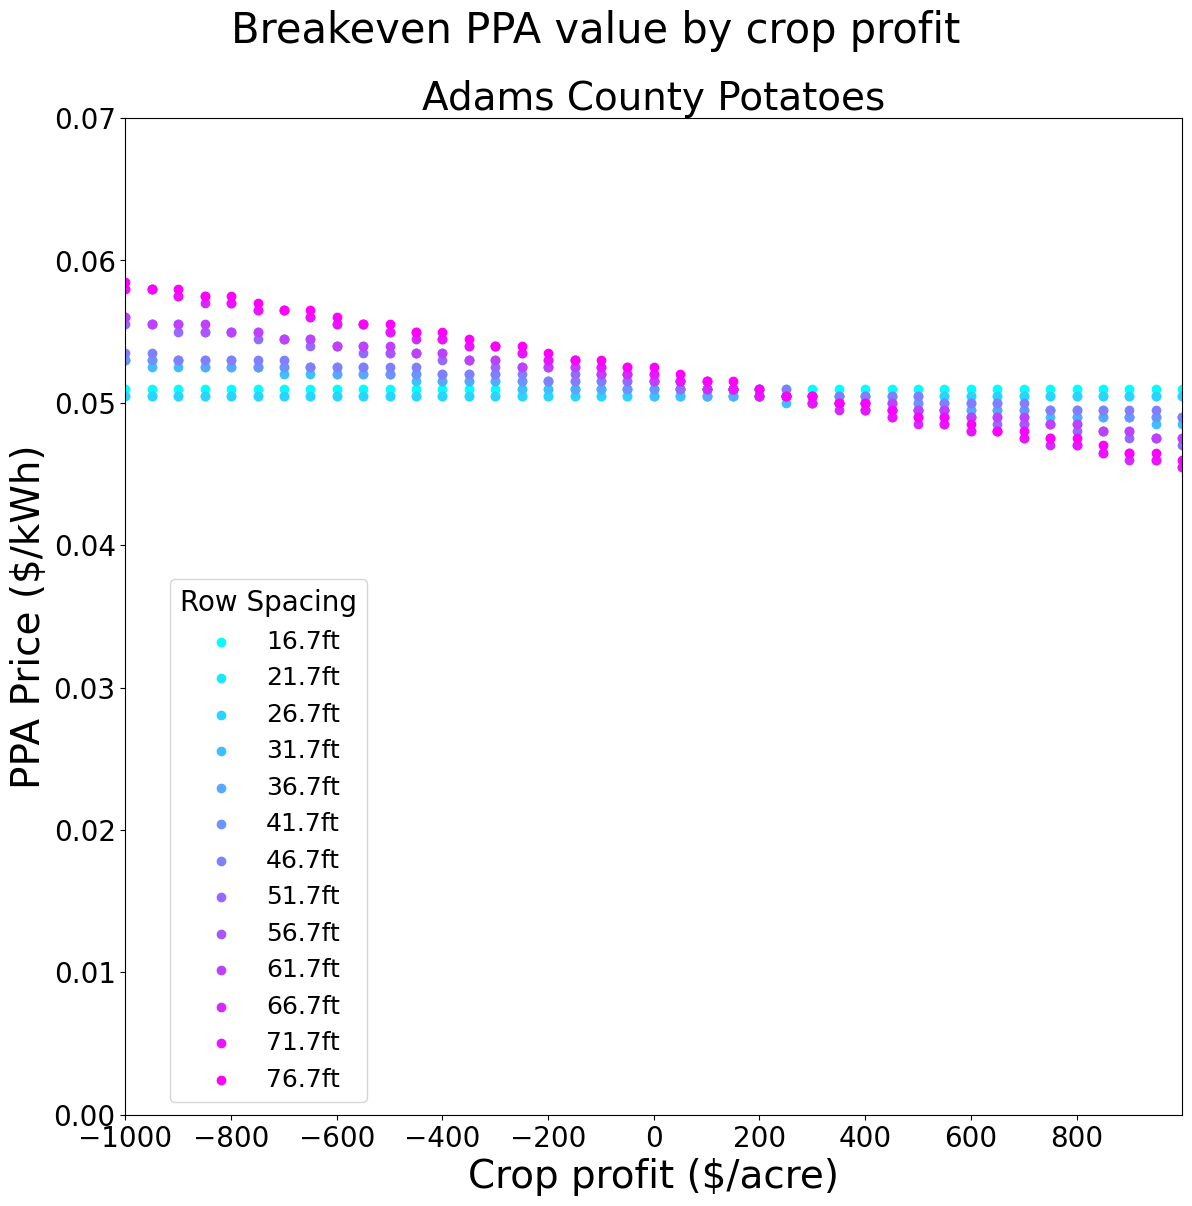

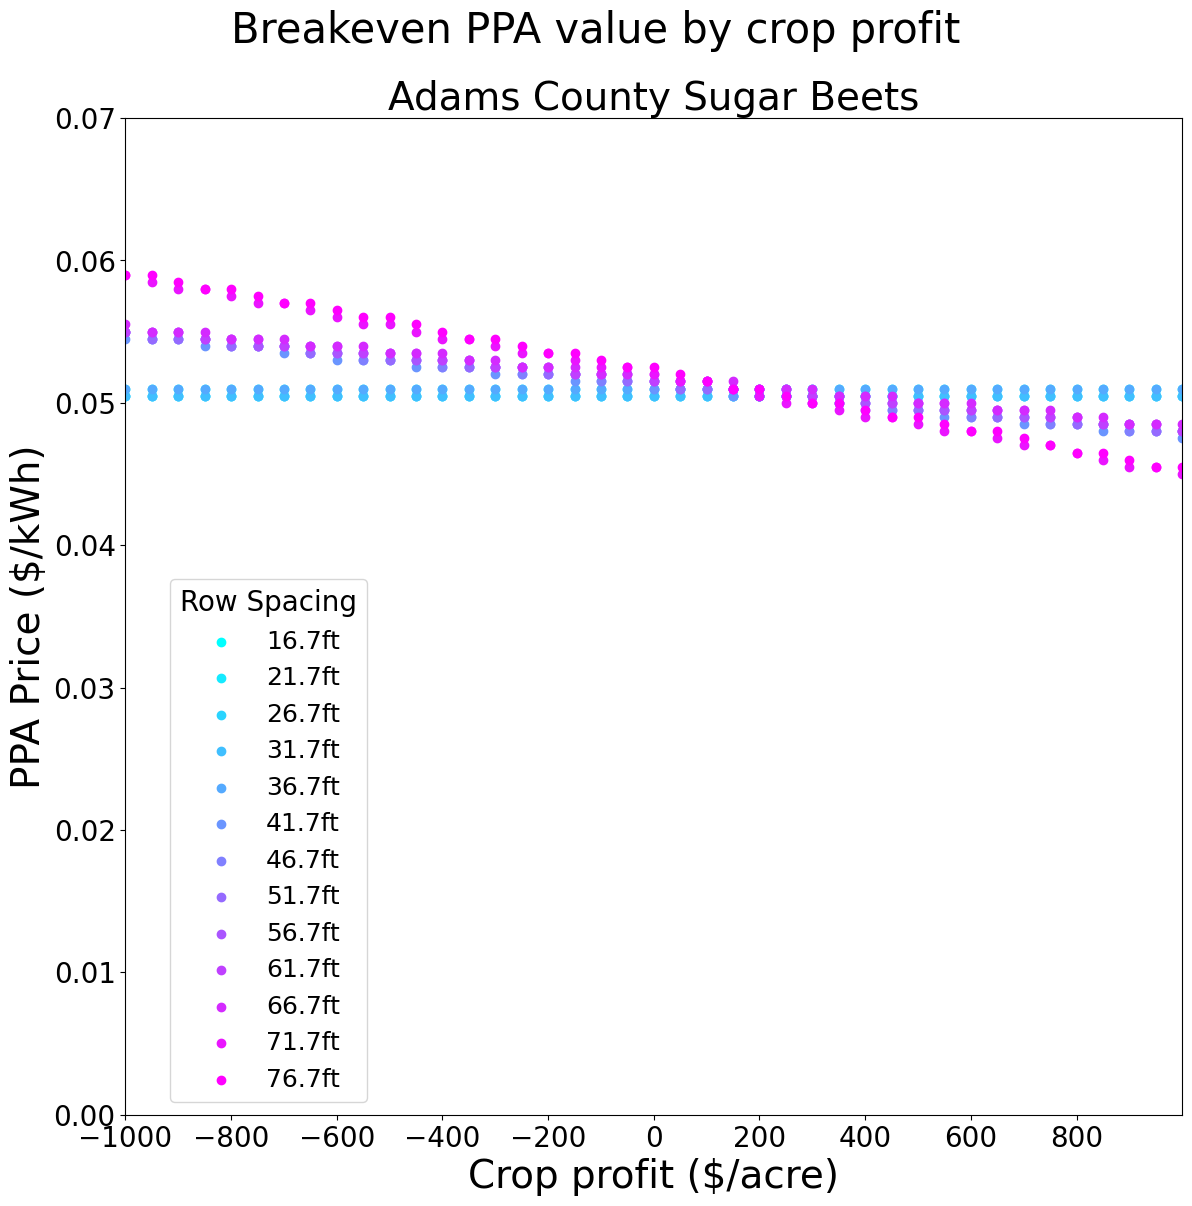

In [7]:
acres = 160.0

max_profit_per_acre = 1000

xtics = range(-1 * max_profit_per_acre, max_profit_per_acre, 200)
#xlabels = breakeven_lines.columns.get_level_values(1)[0::4] / 100.0

ytics = range(0, 35, 5)
#ylabels = breakeven_lines.index.values[0::5]

for crop in crops:

    fig = plt.figure(figsize=(12, 12))

    color1 = "#00FFFF"
    color2 = "#FF00FF"

    color_grad = get_color_gradient(color1, color2, len(configs))

    ax1 = fig.add_subplot(111)

    ax1.set_title('Adams County ' + crop)
    ax1.set_ylabel('PPA Price ($/kWh)')
    ax1.set_xlabel('Crop profit ($/acre)')

    fig.suptitle('Breakeven PPA value by crop profit', y=1)

    for i, cfg in enumerate(configs):
        cfg_line = breakeven_lines.query('`Config` == @cfg and `Crop` == @crop') 
        cfg_line = cfg_line.iloc[(-1.0*cfg_line["Open Air Crop Profit"]).argsort()[:]]
        ax1.scatter(cfg_line["Open Air Crop Profit"].values / acres, cfg_line["PPA price"].values, label=cfg, color=color_grad[i])

    ax1.set_xbound(-max_profit_per_acre, max_profit_per_acre)
    ax1.set_ybound(0, 0.07)
    ax1.set_xticks(xtics)

    handles, labels = ax1.get_legend_handles_labels()
    print(handles)

    ax1.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.03, 0.55), title="Row Spacing", fontsize = 18)

    fig.tight_layout(pad=0.5)
    fig.savefig("breakeven_lines_adams_co_" + crop + ".png")

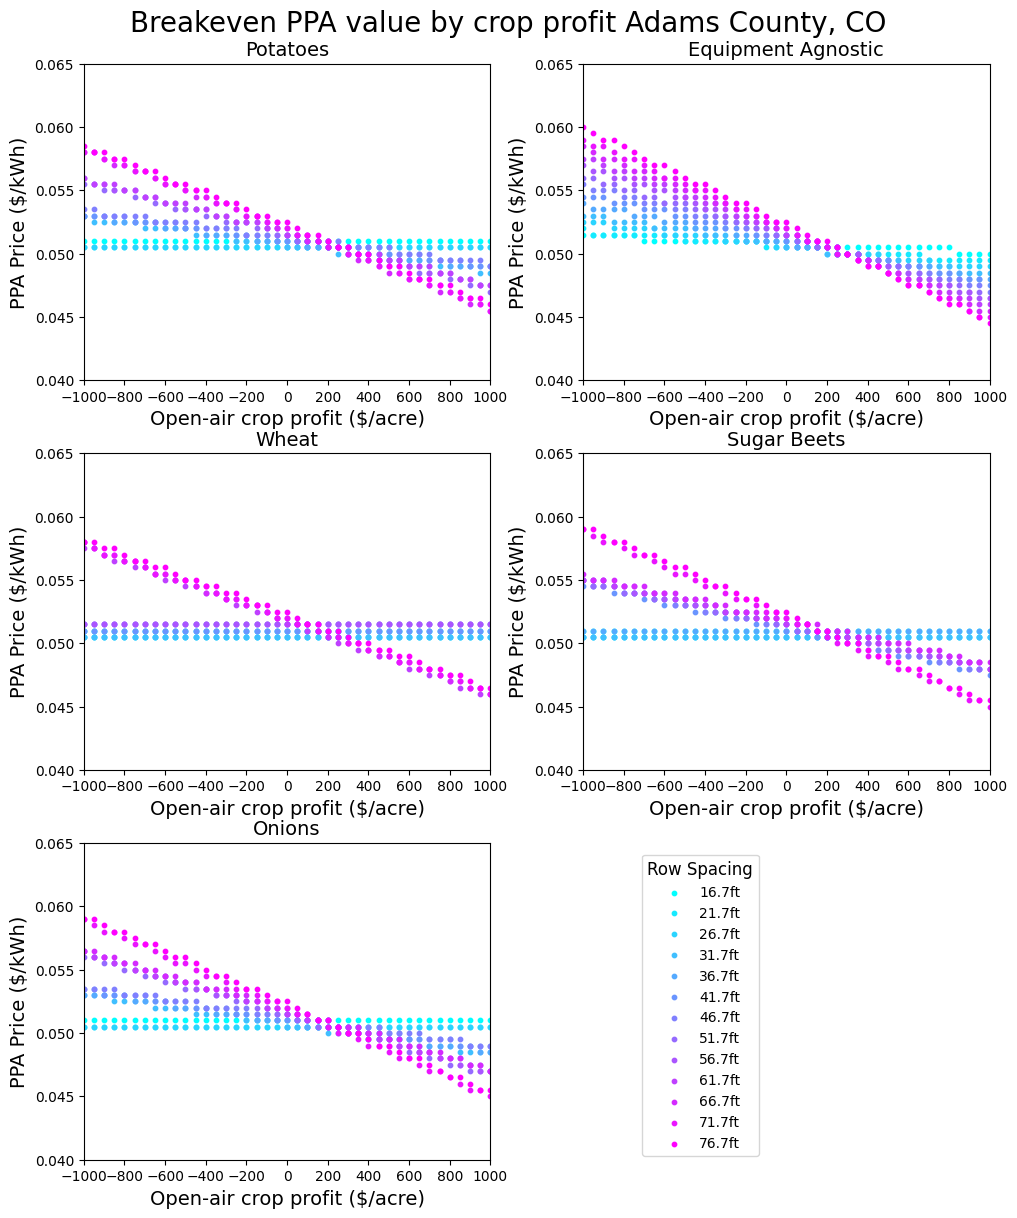

In [9]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 20
        
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

acres = 160.0

max_profit_per_acre = 1000

xtics = range(-1 * max_profit_per_acre, max_profit_per_acre + 1, 200)
#xlabels = breakeven_lines.columns.get_level_values(1)[0::4] / 100.0

ytics = range(0, 35, 5)
#ylabels = breakeven_lines.index.values[0::5]

fig = plt.figure(figsize=(10, 12))

color1 = "#00FFFF"
color2 = "#FF00FF"

color_grad = get_color_gradient(color1, color2, len(configs))
j = 1

for crop in crops:
    ax1 = fig.add_subplot(3, 2, j)

    if crop == "Equipment agnostic":
        ax1.set_title("Equipment Agnostic")
    else:
        ax1.set_title(crop)
    ax1.set_ylabel('PPA Price ($/kWh)')
    ax1.set_xlabel('Open-air crop profit ($/acre)')

    fig.suptitle('Breakeven PPA value by crop profit Adams County, CO', y=1)

    for i, cfg in enumerate(configs):
        cfg_line = breakeven_lines.query('`Config` == @cfg and `Crop` == @crop') 
        cfg_line = cfg_line.iloc[(-1.0*cfg_line["Open Air Crop Profit"]).argsort()[:]]
        ax1.scatter(cfg_line["Open Air Crop Profit"].values / acres, cfg_line["PPA price"].values, label=cfg, color=color_grad[i], s=10)

    ax1.set_xbound(-max_profit_per_acre, max_profit_per_acre)
    ax1.set_ybound(0.04, 0.065)
    ax1.set_xticks(xtics)

    handles, labels = ax1.get_legend_handles_labels()

    if j == 5:
        fig.legend(handles, labels, loc='outside right center', bbox_to_anchor=(0.75, 0.17), title="Row Spacing", title_fontsize = 12, borderaxespad=0) #

    j += 1

fig.tight_layout(pad=0.1)
fig.savefig("breakeven_lines_adams_co_composite.png")

[[<Axes: > <Axes: >]
 [<Axes: > <Axes: >]
 [<Axes: > <Axes: >]]


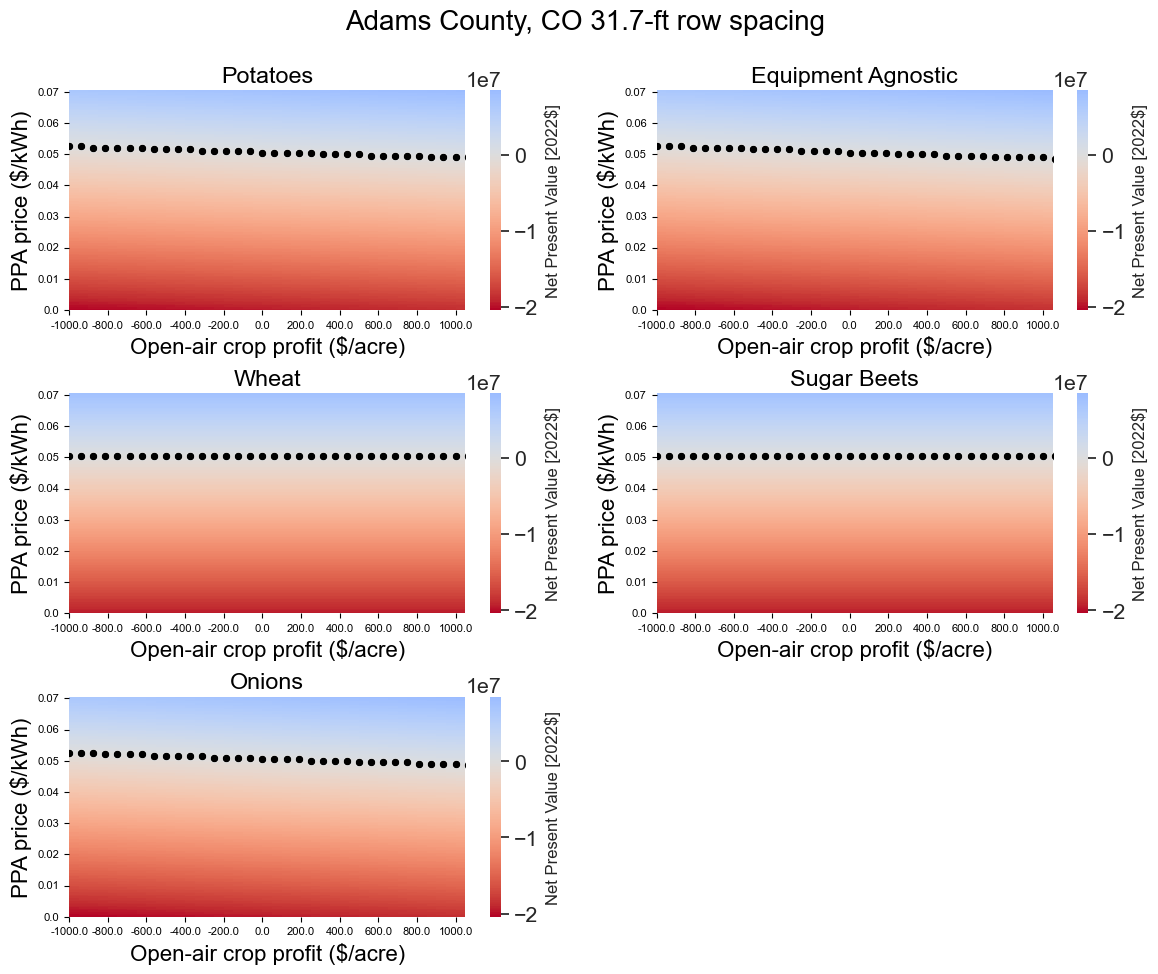

In [ ]:
# Plot code courtesy of Heather Mirletz, see https://github.com/NREL/PV_ICE/commits/development/docs/tutorials/13%20-%20LifetimeVsRecycling%20Analysis%20-%20PLOS%20ONE.ipynb for original

acres = 160

#plt.style.use("seaborn")

plt.rcParams['figure.figsize'] = (12, 10)
fig,axs = plt.subplots(3, 2)
fig.delaxes(axs[2,1])
plt.suptitle('Adams County, CO 31.7-ft row spacing', fontsize = 20)

j=0
k=0

print(axs)

colormax = np.min(adams_df.query('`Config` == "66.7ft" or `Config` == "31.7ft"')["NPV"].values).min()
colormin = np.max(adams_df.query('`Config` == "66.7ft" or `Config` == "31.7ft"')["NPV"].values).max()

for crop in crops:
    us_df = adams_df.query('`Config` == "31.7ft" and `Crop` == @crop')
    us_df = us_df.pivot(index = "PPA price", columns=["Open Air Crop Profit"], values=["NPV"])
    

    xtics = range(0, 41, 4)
    xlabels = us_df.columns.get_level_values(1)[0::4] / acres

    #ytics = range(0, 35, 5)
    #ylabels = us_df.index.values[0::5]
    ytics = range(0, 141, 20)
    ylabels = us_df.index.values[0::20]

    # Utility scale
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(us_df.values, annot = False, 
                cmap="coolwarm_r", #sns.diverging_palette(220, 20, n=200), 
                vmin= colormax,
                vmax= colormin,  
                center = 0.0 , #fix to be dynamic finding pvice value
                cbar_kws={'label': 'Net Present Value [2022$]'},
                ax=axs[j][k])
    ax.invert_yaxis()


    axs[j][k].set_xlabel('Open-air crop profit ($/acre)', fontsize = 16)
    axs[j][k].set_ylabel('PPA price ($/kWh)', fontsize = 16)

    cfg = "31.7ft"

    cfg_line = breakeven_lines.query('`Config` == @cfg and `Crop` == @crop') 
    cfg_line = cfg_line.iloc[(-1.0*cfg_line["Open Air Crop Profit"]).argsort()[:]]
    ax2 = sns.scatterplot(x=cfg_line["Open Air Crop Profit"].values / acres /40 + 20, y=cfg_line["PPA price"].values * 2000, color='black', ax=axs[j][k])

    axs[j][k].set_xticks(ticks=xtics, labels=xlabels, rotation=0, fontsize = 8)
    axs[j][k].set_yticks(ticks=ytics, labels=ylabels, fontsize = 8)
    if crop == "Equipment agnostic":
        axs[j][k].set_title("Equipment Agnostic")
    else:
        axs[j][k].set_title(crop)
    ax.figure.axes[-1].yaxis.label.set_size(12)


    k += 1
    if k > 1:
        k=0
        j += 1
    


plt.subplots_adjust(top=0.9)
fig.tight_layout(h_pad=0.5)

plt.savefig('heatmap-adams-co-31.7-multi-crop.png')

[[<Axes: > <Axes: >]
 [<Axes: > <Axes: >]
 [<Axes: > <Axes: >]]


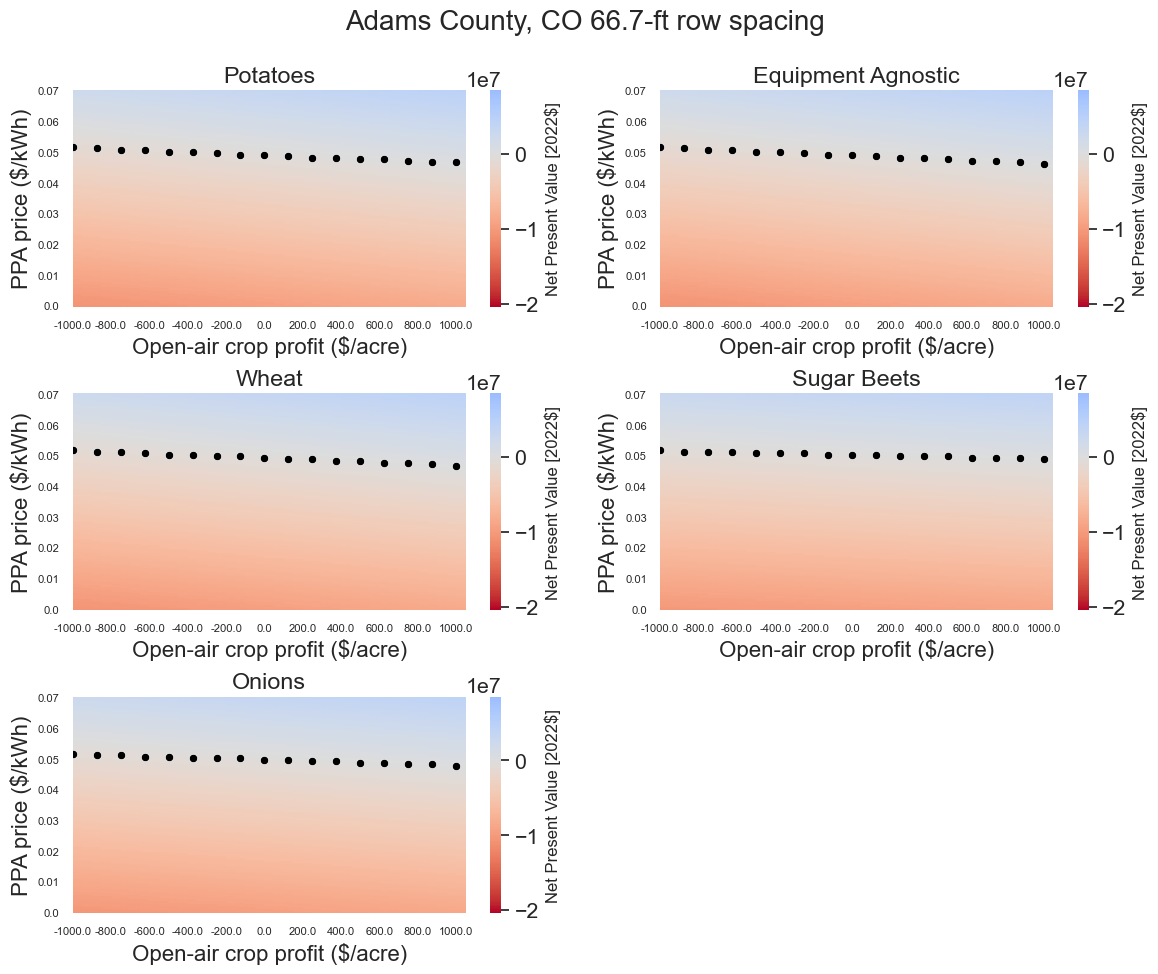

In [ ]:
# Plot code courtesy of Heather Mirletz, see https://github.com/NREL/PV_ICE/commits/development/docs/tutorials/13%20-%20LifetimeVsRecycling%20Analysis%20-%20PLOS%20ONE.ipynb for original


acres = 160

#plt.style.use("seaborn")

plt.rcParams['figure.figsize'] = (12, 10)
fig,axs = plt.subplots(3, 2)
fig.delaxes(axs[2,1])
plt.suptitle('Adams County, CO 66.7-ft row spacing', fontsize = 20)

j=0
k=0

print(axs)

colormax = np.min(adams_df.query('`Config` == "66.7ft" or `Config` == "31.7ft"')["NPV"].values).min()
colormin = np.max(adams_df.query('`Config` == "66.7ft" or `Config` == "31.7ft"')["NPV"].values).max()

for crop in crops:
    us_df = adams_df.query('`Config` == "66.7ft" and `Crop` == @crop')
    us_df = us_df.pivot(index = "PPA price", columns=["Open Air Crop Profit"], values=["NPV"])

    xtics = range(0, 41, 4)
    xlabels = us_df.columns.get_level_values(1)[0::4] / acres

    #ytics = range(0, 35, 5)
    #ylabels = us_df.index.values[0::5]
    ytics = range(0, 141, 20)
    ylabels = us_df.index.values[0::20]

    # Utility scale
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(us_df.values, annot = False, 
                cmap="coolwarm_r", #sns.diverging_palette(220, 20, n=200), 
                vmin= colormax,
                vmax= colormin,  
                center = 0.0 , #fix to be dynamic finding pvice value
                cbar_kws={'label': 'Net Present Value [2022$]'},
                ax=axs[j][k])
    ax.invert_yaxis()

    cfg = '66.7ft'
    cfg_line = breakeven_lines.query('`Config` == @cfg and `Crop` == @crop') 
    cfg_line = cfg_line.iloc[(-1.0*cfg_line["Open Air Crop Profit"]).argsort()[:]]
    ax2 = sns.scatterplot(x=cfg_line["Open Air Crop Profit"].values / acres /40 + 20, y=cfg_line["PPA price"].values * 2000, color='black', ax=axs[j][k])

    axs[j][k].set_xlabel('Open-air crop profit ($/acre)', fontsize = 16)
    axs[j][k].set_ylabel('PPA price ($/kWh)', fontsize = 16)


    axs[j][k].set_xticks(ticks=xtics, labels=xlabels, rotation=0, fontsize = 8)
    axs[j][k].set_yticks(ticks=ytics, labels=ylabels, fontsize = 8)
    if crop == "Equipment agnostic":
        axs[j][k].set_title("Equipment Agnostic")
    else:
        axs[j][k].set_title(crop)
    ax.figure.axes[-1].yaxis.label.set_size(12)

    k += 1
    if k > 1:
        k=0
        j += 1
    


plt.subplots_adjust(top=0.9)
fig.tight_layout(h_pad=0.5)

plt.savefig('heatmap-adams-co-66.7-multi-crop.png')

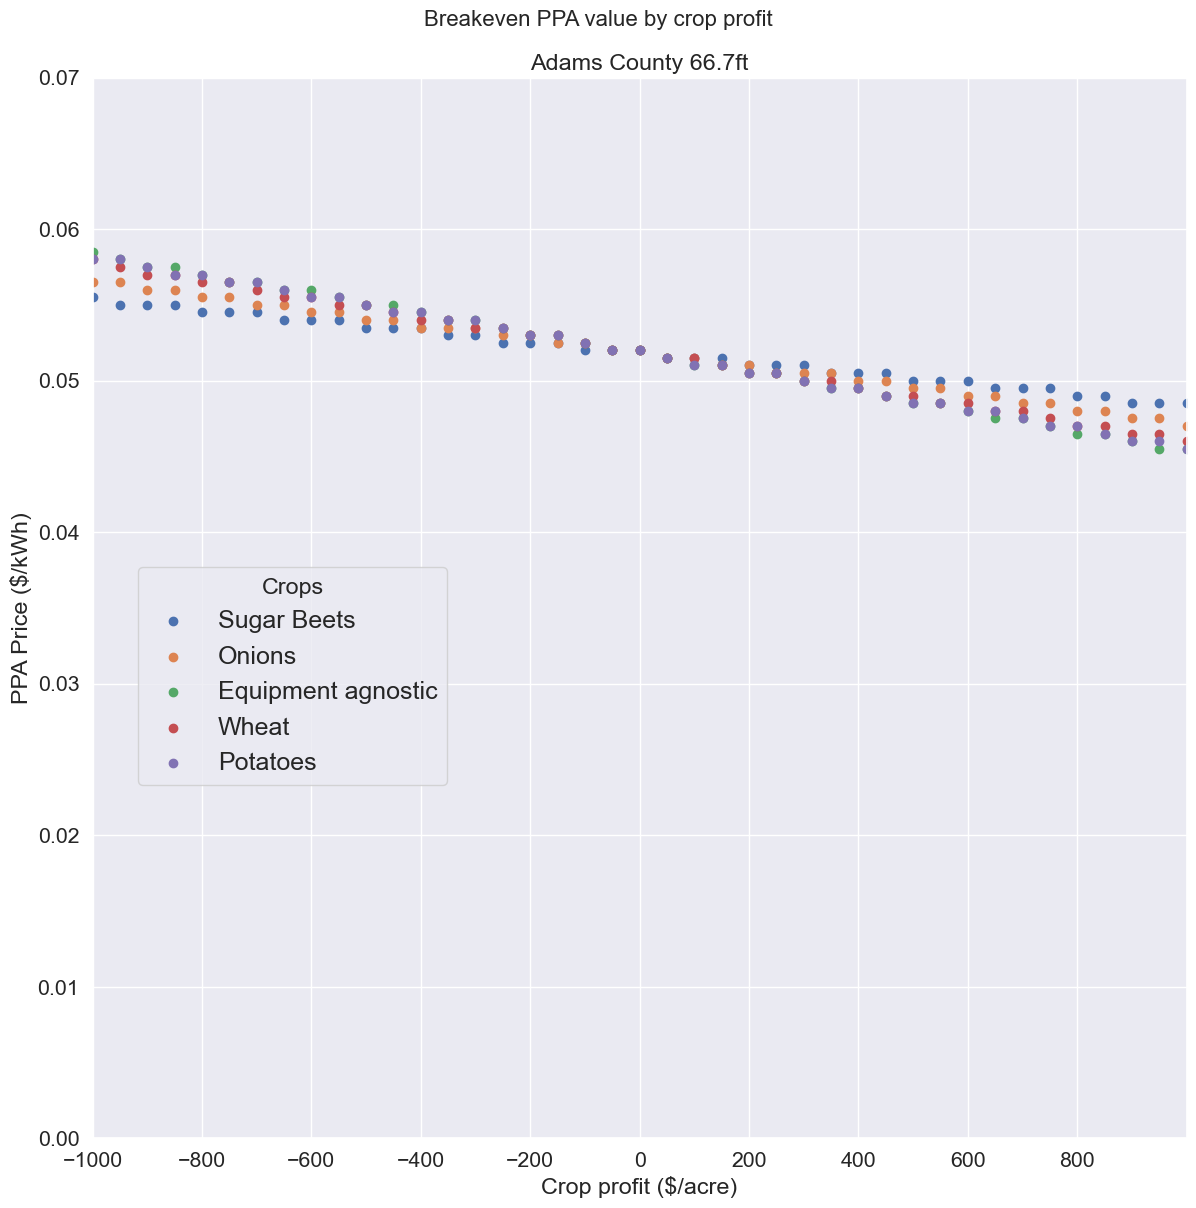

In [57]:
xtics = range(-1 * max_profit_per_acre, max_profit_per_acre, 200)
#xlabels = breakeven_lines.columns.get_level_values(1)[0::4] / 100.0

ytics = range(0, 35, 5)
#ylabels = breakeven_lines.index.values[0::5]

cfg = '66.7ft'

fig = plt.figure(figsize=(12, 12))

color1 = "#00FFFF"
color2 = "#FF00FF"

color_grad = get_color_gradient(color1, color2, len(configs))

ax1 = fig.add_subplot(111)

ax1.set_title('Adams County 66.7ft')
ax1.set_ylabel('PPA Price ($/kWh)')
ax1.set_xlabel('Crop profit ($/acre)')

fig.suptitle('Breakeven PPA value by crop profit', y=1)

for i, crop in enumerate(crops):
    cfg_line = breakeven_lines.query('`Config` == @cfg and `Crop` == @crop') 
    cfg_line = cfg_line.iloc[(-1.0*cfg_line["Open Air Crop Profit"]).argsort()[:]]
    ax1.scatter(cfg_line["Open Air Crop Profit"].values / acres, cfg_line["PPA price"].values, label=crop)

ax1.set_xbound(-1000, 1000)
ax1.set_ybound(0, 0.07)
ax1.set_xticks(xtics)

handles, labels = ax1.get_legend_handles_labels()

ax1.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.03, 0.55), title="Crops", fontsize = 18)

fig.tight_layout(pad=0.5)
fig.savefig("breakeven_lines_adams_co_66.7.png")

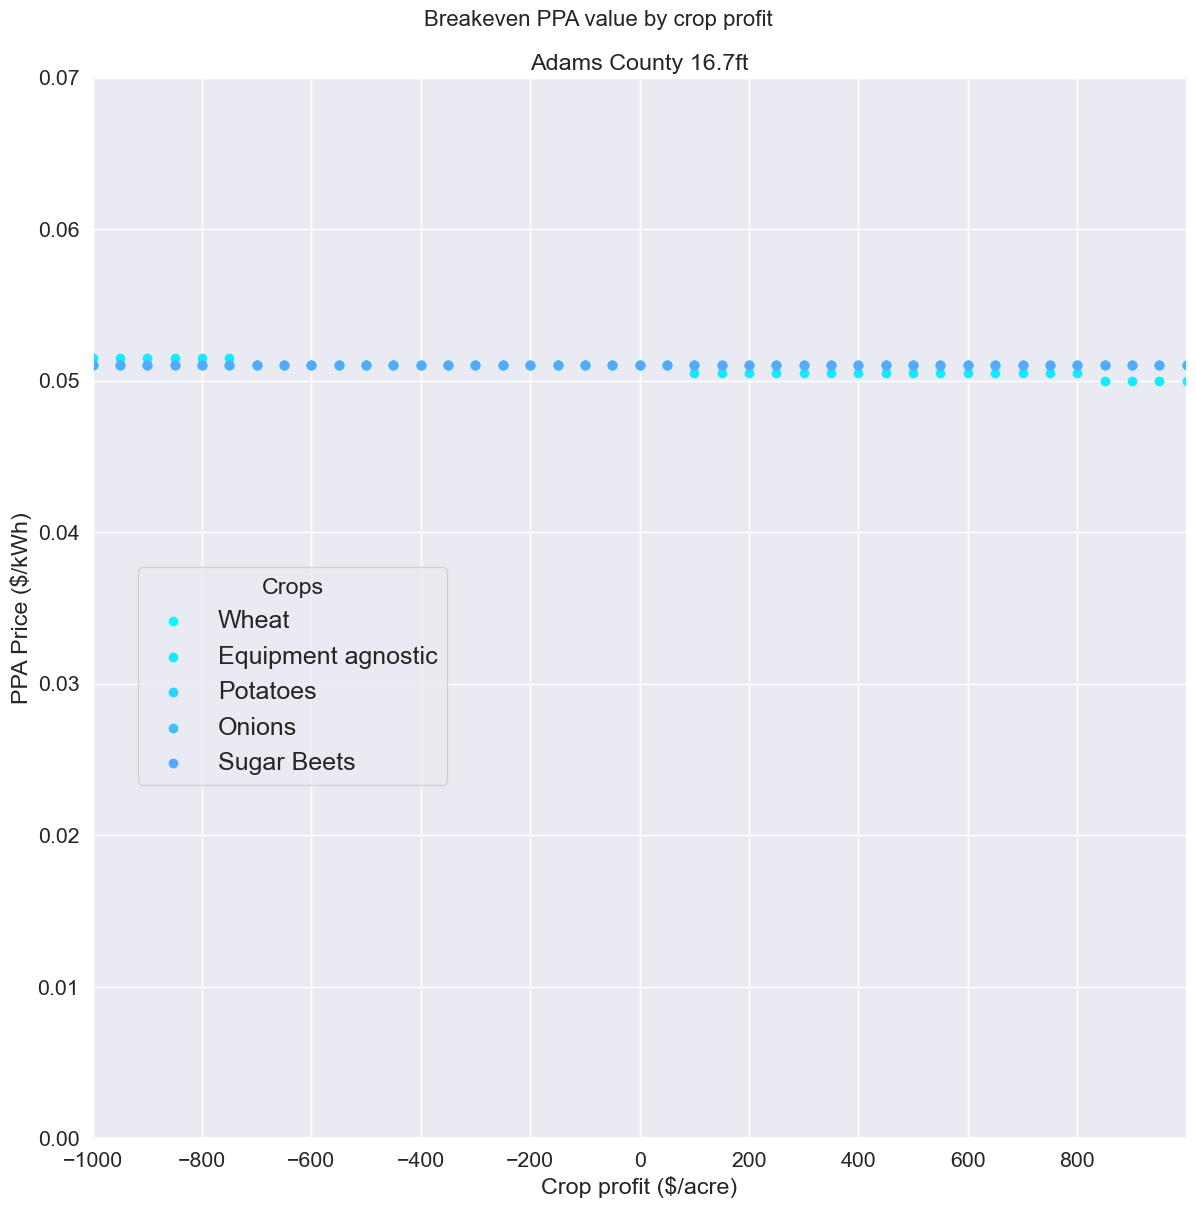

In [ ]:
xtics = range(-1 * max_profit_per_acre, max_profit_per_acre, 200)
#xlabels = breakeven_lines.columns.get_level_values(1)[0::4] / 100.0

ytics = range(0, 35, 5)
#ylabels = breakeven_lines.index.values[0::5]

cfg = '16.7ft'

fig = plt.figure(figsize=(12, 12))

color1 = "#00FFFF"
color2 = "#FF00FF"

color_grad = get_color_gradient(color1, color2, len(configs))

ax1 = fig.add_subplot(111)

ax1.set_title('Adams County 16.7ft')
ax1.set_ylabel('PPA Price ($/kWh)')
ax1.set_xlabel('Crop profit ($/acre)')

fig.suptitle('Breakeven PPA value by crop profit', y=1)

for i, crop in enumerate(crops):
    cfg_line = breakeven_lines.query('`Config` == @cfg and `Crop` == @crop') 
    cfg_line = cfg_line.iloc[(-1.0*cfg_line["Open Air Crop Profit"]).argsort()[:]]
    ax1.scatter(cfg_line["Open Air Crop Profit"].values / acres, cfg_line["PPA price"].values, label=crop, color=color_grad[i])

ax1.set_xbound(-1000, 1000)
ax1.set_ybound(0, 0.07)
ax1.set_xticks(xtics)

handles, labels = ax1.get_legend_handles_labels()
print(handles)


ax1.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.03, 0.55), title="Crops", fontsize = 18)

fig.tight_layout(pad=0.5)
fig.savefig("breakeven_lines_adams_co_16.7.png")

In [51]:
print(configs)

['16.7ft', '21.7ft', '26.7ft', '31.7ft', '36.7ft', '41.7ft', '46.7ft', '51.7ft', '56.7ft', '61.7ft', '66.7ft', '71.7ft', '76.7ft']


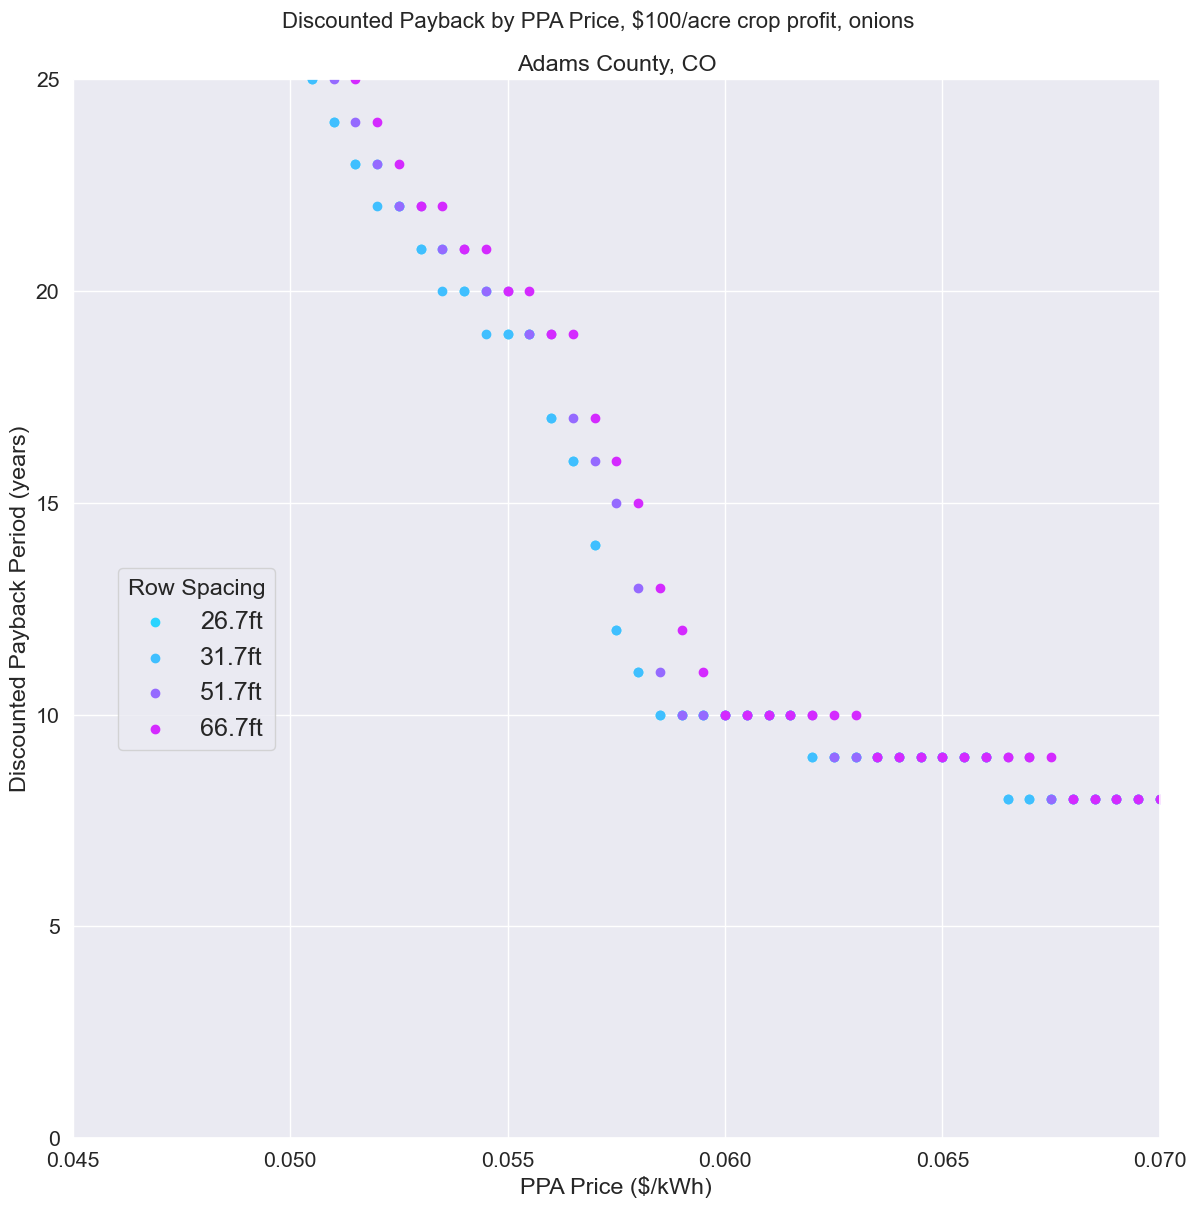

In [31]:
crop = 'Onions'
profit = 100 * acres

fig = plt.figure(figsize=(12, 12))

color1 = "#00FFFF"
color2 = "#FF00FF"

color_grad = get_color_gradient(color1, color2, len(configs))

ax1 = fig.add_subplot(111)

ax1.set_title('Adams County, CO')
ax1.set_ylabel('Discounted Payback Period (years)')
ax1.set_xlabel('PPA Price ($/kWh)')


fig.suptitle('Discounted Payback by PPA Price, $100/acre crop profit, onions', y=1)
subset_cfgs = ['26.7ft', '31.7ft', '51.7ft', '66.7ft']
color_idx = [2, 3, 7, 10]

for i in range(0,4):
    cfg = subset_cfgs[i]
    idx = color_idx[i]
    cfg_line = adams_df.query('`Config` == @cfg and `Crop` == @crop and `Open Air Crop Profit` == @profit') 
    cfg_line = cfg_line.iloc[(-1.0*cfg_line["PPA price"]).argsort()[:]]
    ax1.scatter(cfg_line["PPA price"].values, cfg_line["Discounted Payback"].values, label=cfg, color=color_grad[idx])

ax1.set_xbound(0.045, 0.07)
ax1.set_ybound(0, 25)
#ax1.set_xticks(xtics)

handles, labels = ax1.get_legend_handles_labels()

ax1.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.03, 0.55), title="Row Spacing", fontsize = 18)

fig.tight_layout(pad=0.5)
fig.savefig("payback_periods_100_crop_profit.png")

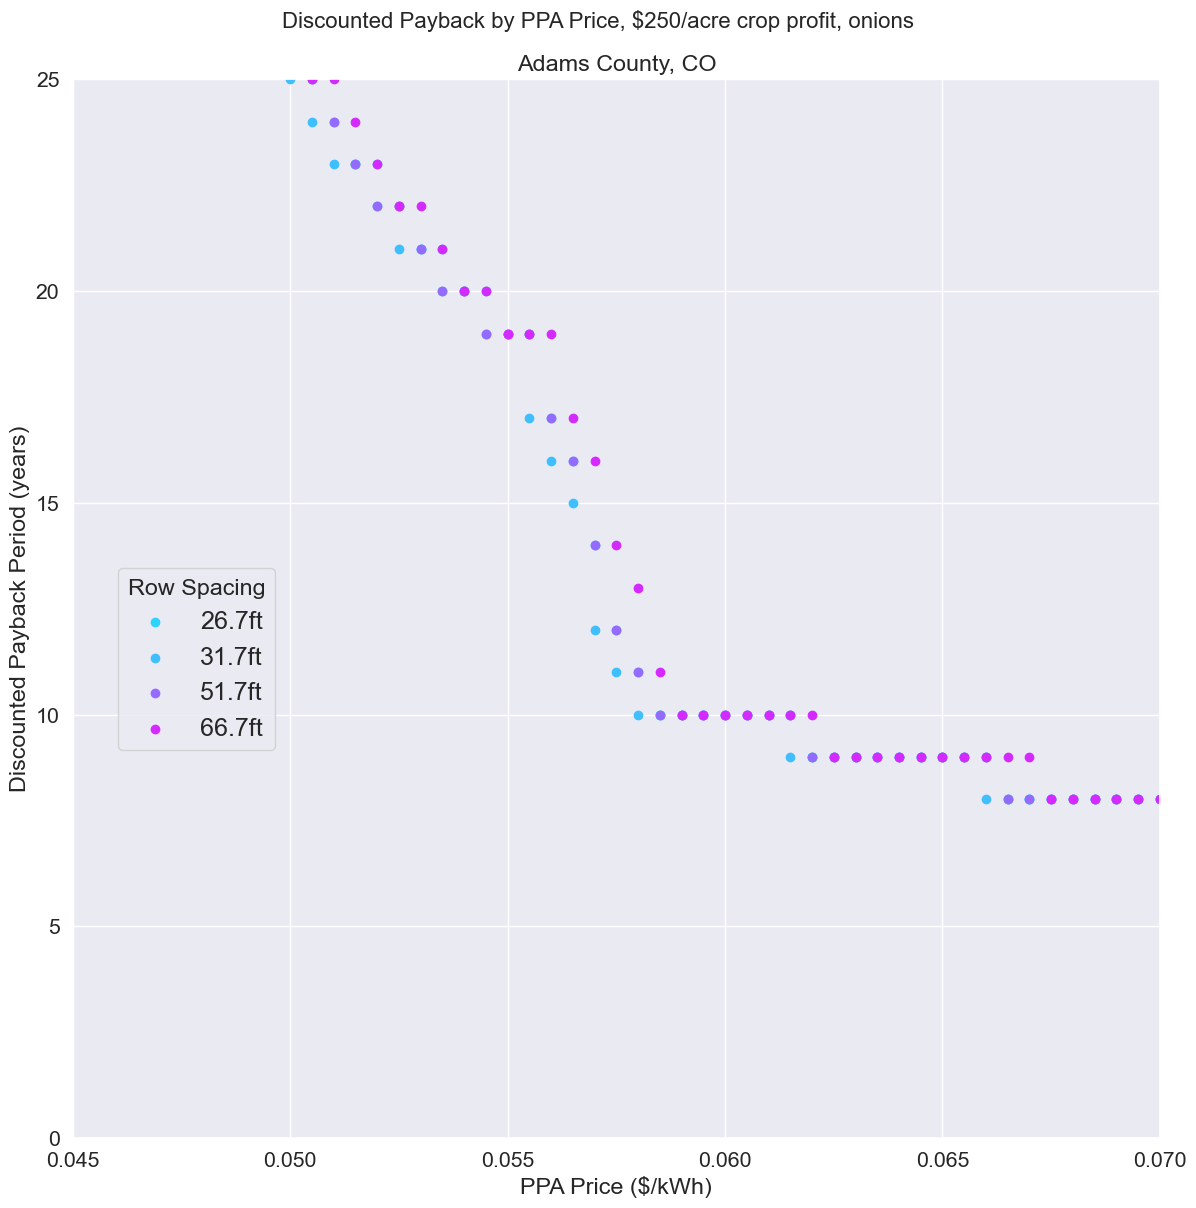

In [32]:
crop = 'Onions'
profit = 250 * acres

fig = plt.figure(figsize=(12, 12))

color1 = "#00FFFF"
color2 = "#FF00FF"

color_grad = get_color_gradient(color1, color2, len(configs))

ax1 = fig.add_subplot(111)

ax1.set_title('Adams County, CO')
ax1.set_ylabel('Discounted Payback Period (years)')
ax1.set_xlabel('PPA Price ($/kWh)')

fig.suptitle('Discounted Payback by PPA Price, $250/acre crop profit, onions', y=1)
subset_cfgs = ['26.7ft', '31.7ft', '51.7ft', '66.7ft']
color_idx = [2, 3, 7, 10]

for i in range(0,4):
    cfg = subset_cfgs[i]
    idx = color_idx[i]
    cfg_line = adams_df.query('`Config` == @cfg and `Crop` == @crop and `Open Air Crop Profit` == @profit') 
    cfg_line = cfg_line.iloc[(-1.0*cfg_line["PPA price"]).argsort()[:]]
    ax1.scatter(cfg_line["PPA price"].values, cfg_line["Discounted Payback"].values, label=cfg, color=color_grad[idx])

ax1.set_xbound(0.045, 0.07)
ax1.set_ybound(0, 25)
#ax1.set_xticks(xtics)

handles, labels = ax1.get_legend_handles_labels()

ax1.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.03, 0.55), title="Row Spacing", fontsize = 18)

fig.tight_layout(pad=0.5)
fig.savefig("payback_periods_250_crop_profit.png")

In [86]:
breakeven_df = pd.read_csv("co_multicounty_breakeven_targets.csv")

crop_profits = set(breakeven_df["Open Air Crop Profit"])
crops = set(breakeven_df["Crop"])
counties = breakeven_df.County.unique()
cfg = "16.7ft"
dfs = []
for cnty in counties[34::]:
    for cfg in configs:
        for cp in crop_profits:
            for crop in crops:
                df_c = breakeven_df.query('`Open Air Crop Profit` == @cp and NPV > 0 and Config == @cfg and Crop == @crop and County == @cnty')
                if df_c.size > 0:
                    df_breakeven_multi_county = df_c.iloc[(df_c["NPV"]).abs().argsort()][:1]
                    vals = [cnty, cfg, cp, crop, df_breakeven_multi_county["PPA price"].values[0]]
                    dfs.append(df_breakeven_multi_county)

breakeven_lines_multi_county = pd.concat(dfs)
breakeven_lines_multi_county.to_csv("breakeven_multi_county_2.csv")

In [84]:
counties = breakeven_df.County.unique()
print(counties)

['ADAMS' 'ALAMOSA' 'ARAPAHOE' 'ARCHULETA' 'BACA' 'BENT' 'BOULDER'
 'BROOMFIELD' 'CHAFFEE' 'CHEYENNE' 'CLEAR CREEK' 'CONEJOS' 'COSTILLA'
 'CROWLEY' 'CUSTER' 'DELTA' 'DENVER' 'DOLORES' 'DOUGLAS' 'EAGLE' 'EL PASO'
 'ELBERT' 'FREMONT' 'GARFIELD' 'GILPIN' 'GRAND' 'GUNNISON' 'HINSDALE'
 'HUERFANO' 'JACKSON' 'JEFFERSON' 'KIOWA' 'KIT CARSON' 'LA PLATA' 'LAKE'
 'LARIMER' 'LAS ANIMAS' 'LINCOLN' 'LOGAN' 'MESA' 'MINERAL' 'MOFFAT'
 'MONTEZUMA' 'MONTROSE' 'MORGAN' 'OTERO' 'OURAY' 'PARK' 'PHILLIPS'
 'PITKIN' 'PROWERS' 'PUEBLO' 'RIO BLANCO' 'RIO GRANDE' 'ROUTT' 'SAGUACHE'
 'SAN JUAN' 'SAN MIGUEL' 'SEDGWICK' 'SUMMIT' 'TELLER' 'WASHINGTON' 'WELD'
 'YUMA']


In [ ]:
breakeven_lines_multi_county = pd.concat(dfs)
breakeven_lines_multi_county.to_csv("breakeven_multi_county.csv")

In [16]:
bk1 = pd.read_csv("breakeven_multi_county.csv")
bk2 = pd.read_csv("breakeven_multi_county_2.csv")

breakeven_lines_multi_county = pd.concat([bk1, bk2])

print(breakeven_lines_multi_county.size)
print(len(breakeven_lines_multi_county.County.unique()))


1137708
64


In [20]:
upv_ppa = breakeven_lines_multi_county.query('`Config` == "26.7ft" and `Crop` == "Onions" and `Open Air Crop Profit` == 0')
print(upv_ppa)

       Unnamed: 0.1  Unnamed: 0      County        Lat        Long  Config  \
152          317850        1050       ADAMS  39.873634 -104.337935  26.7ft   
1127         319350          75     ALAMOSA  37.572892 -105.788287  26.7ft   
2102         322725         975    ARAPAHOE  39.649772 -104.339219  26.7ft   
3077         324825         600   ARCHULETA  37.193596 -107.048329  26.7ft   
4052         327225         525        BACA  37.319183 -102.560469  26.7ft   
...             ...         ...         ...        ...         ...     ...   
24358        464400        1575      SUMMIT  39.634170 -106.116379  26.7ft   
25333        466050         750      TELLER  38.882172 -105.161826  26.7ft   
26308        468975        1200  WASHINGTON  39.971062 -103.201253  26.7ft   
27283        471675        1425        WELD  40.554840 -104.392525  26.7ft   
28258        474000        1275        YUMA  40.002899 -102.424226  26.7ft   

         Crop  Solar capacity         CAPEX  PPA price  Open Ai

In [28]:
counties = breakeven_lines_multi_county.County.unique()

dfs = []

for county in counties:
    ppa_to_beat = breakeven_lines_multi_county.query('`County` == @county and `Config` == "26.7ft" and `Crop` == "Onions" and `Open Air Crop Profit` == 0')["PPA price"].values[0]
    exceeds_upv = breakeven_lines_multi_county.query('`County` == @county and `PPA price` < @ppa_to_beat')
    min_crop_price = min(exceeds_upv["Open Air Crop Profit"].values)
    min_crop_configs = exceeds_upv.query('`Open Air Crop Profit` == @min_crop_price')

    dfs.append(min_crop_configs)

beats_upv = pd.concat(dfs)
beats_upv.to_csv("minimum_crop_price_to_lower_ppa.csv")

In [7]:
equipment_data = pd.read_excel("equipment_width_and_crop_profit_factor.xlsx", header=1)
equipment_data = equipment_data.set_index("Row spacing (ft)")

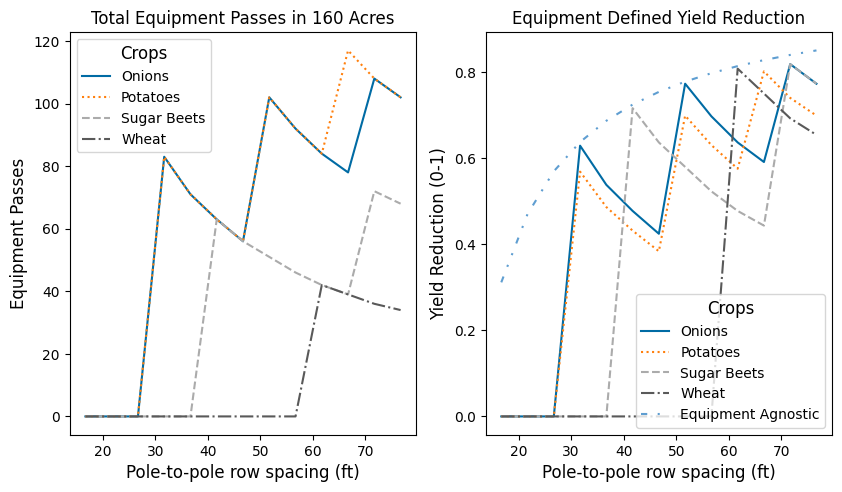

In [8]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16
        
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.style.use('tableau-colorblind10')

cols = ["Onions", "Potatoes", "Sugar Beets", "Wheat"]

fig = plt.figure(figsize=(8.5, 5))

ax1 = fig.add_subplot(121)

ax1.set_title('Total Equipment Passes in 160 Acres')
ax1.set_ylabel('Equipment Passes')
ax1.set_xlabel('Pole-to-pole row spacing (ft)')

# fig.suptitle('Breakeven PPA value by crop profit', y=1)
# fig.suptitle('Breakeven PPA value by crop profit', y=1)
# Line styles
line_styles = ['solid', 'dotted', 'dashed', 'dashdot', (0, (3, 5, 1, 5, 1, 5))]

for i, col in enumerate(cols):
    ax1.plot(equipment_data.index, equipment_data[col + " - rows"], label=col, linestyle=line_styles[i])



handles, labels = ax1.get_legend_handles_labels()

ax1.legend(handles, labels, loc='upper left', title="Crops",title_fontsize = 12)

cols = ["Onions", "Potatoes", "Sugar Beets", "Wheat", "Equipment Agnostic"]

ax1 = fig.add_subplot(122)

ax1.set_title('Equipment Defined Yield Reduction')
ax1.set_ylabel('Yield Reduction (0-1)')
ax1.set_xlabel('Pole-to-pole row spacing (ft)')



for i, col in enumerate(cols):
    ax1.plot(equipment_data.index, equipment_data[col + " - profit"].values, label=col, linestyle=line_styles[i])

handles, labels = ax1.get_legend_handles_labels()

ax1.legend(handles, labels, title="Crops",title_fontsize = 12)

fig.tight_layout(pad=1)
fig.savefig("equipment_passes_plus_farmable area.png")

   Capacity (W)  Cost ($/Wdc)
0        500000         2.275
1       5000000         1.591
2      10000000         1.474
3      50000000         1.278
4     100000000         1.161


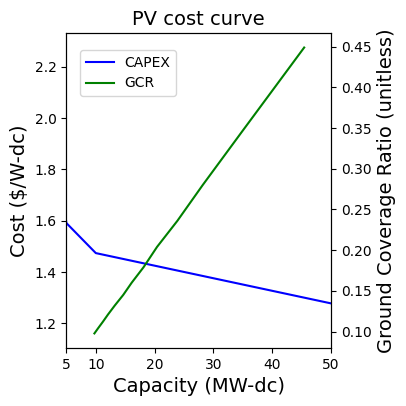

In [23]:
cost_curve = pd.read_excel("cost_curve.xlsx", header=0)
lcoe_data = pd.read_excel("LCOE for row spacing.xlsx")
print(cost_curve)

fig = plt.figure(figsize=(4, 4))

ax1 = fig.add_subplot(111)

ax1.set_title('PV cost curve')
ax1.set_ylabel('Cost ($/W-dc)')
ax1.set_xlabel('Capacity (MW-dc)')

ax1.set_xlim(5000000, 50000000)

ax1.set_xticks(ticks=[5000000, 10000000, 20000000, 30000000, 40000000, 50000000], labels=['5', '10', '20', '30', '40', '50'])

# fig.suptitle('Breakeven PPA value by crop profit', y=1)
ax1.plot(cost_curve['Capacity (W)'], cost_curve['Cost ($/Wdc)'], color='b', label="CAPEX")
handles1, labels1 = ax1.get_legend_handles_labels()

ax2 = ax1.twinx()
ax2.set_ylabel("Ground Coverage Ratio (unitless)")
ax2.plot(lcoe_data["System Size (kWdc)"] * 1000.0, lcoe_data["GCR"], color='g', label="GCR")
handles2, labels2 = ax2.get_legend_handles_labels()

fig.legend(handles1 + handles2, labels1 + labels2, bbox_to_anchor=(0.45, 0.9))

fig.tight_layout(pad=0.5)
fig.savefig("cost_curve.png")

In [49]:
cfg = '31.7ft'
crop = 'Onions'

cfg_line = breakeven_lines.query('`Config` == @cfg and `Crop` == @crop') 
print(cfg_line)

        Unnamed: 0 County        Lat        Long  Config    Crop  \
105400       21400  ADAMS  39.873634 -104.337935  31.7ft  Onions   
105220       21220  ADAMS  39.873634 -104.337935  31.7ft  Onions   
105210       21210  ADAMS  39.873634 -104.337935  31.7ft  Onions   
105030       21030  ADAMS  39.873634 -104.337935  31.7ft  Onions   
105040       21040  ADAMS  39.873634 -104.337935  31.7ft  Onions   
104670       20670  ADAMS  39.873634 -104.337935  31.7ft  Onions   
104490       20490  ADAMS  39.873634 -104.337935  31.7ft  Onions   
104860       20860  ADAMS  39.873634 -104.337935  31.7ft  Onions   
104680       20680  ADAMS  39.873634 -104.337935  31.7ft  Onions   
104850       20850  ADAMS  39.873634 -104.337935  31.7ft  Onions   
104500       20500  ADAMS  39.873634 -104.337935  31.7ft  Onions   
104145       20145  ADAMS  39.873634 -104.337935  31.7ft  Onions   
103790       19790  ADAMS  39.873634 -104.337935  31.7ft  Onions   
104135       20135  ADAMS  39.873634 -104.337935

In [15]:
cost_sensitivity_df = pd.read_csv("adams_co_price_comparison.csv")

crop_profits = set(cost_sensitivity_df["Open Air Crop Profit"])
price_sensitivity = set(cost_sensitivity_df["$/W"])

dfs = []
for cf in configs:
    for price in price_sensitivity:
            df_c = cost_sensitivity_df.query('`Config` == @cf and NPV > 0 and `$/W` == @price ')
            df_breakeven = df_c.iloc[(df_c["NPV"]).abs().argsort()][:1]
            dfs.append(df_breakeven)

max_npv_df = pd.concat(dfs)
max_npv_df.to_csv("breakeven_price_sweep_510.csv")

In [16]:
cfg = max_npv_df.query('`Open Air Crop Profit` == 24000 and `$/W` == 1.6')
print(cfg.empty)

True


<class 'list'>
[<matplotlib.collections.PathCollection object at 0x00000220F0F6B2D0>, <matplotlib.collections.PathCollection object at 0x00000220EF577C90>, <matplotlib.collections.PathCollection object at 0x00000220EF3E7FD0>, <matplotlib.collections.PathCollection object at 0x00000220EF403390>, <matplotlib.collections.PathCollection object at 0x00000220EF403650>, <matplotlib.collections.PathCollection object at 0x00000220EF4D8410>, <matplotlib.collections.PathCollection object at 0x00000220EF40A710>, <matplotlib.collections.PathCollection object at 0x00000220EF408350>, <matplotlib.collections.PathCollection object at 0x00000220EF409210>, <matplotlib.collections.PathCollection object at 0x00000220EF3EDB10>, <matplotlib.collections.PathCollection object at 0x00000220EF40EBD0>, <matplotlib.collections.PathCollection object at 0x00000220EF57F910>, <matplotlib.collections.PathCollection object at 0x00000220EF409590>, <matplotlib.collections.PathCollection object at 0x00000220EF419D90>, <mat

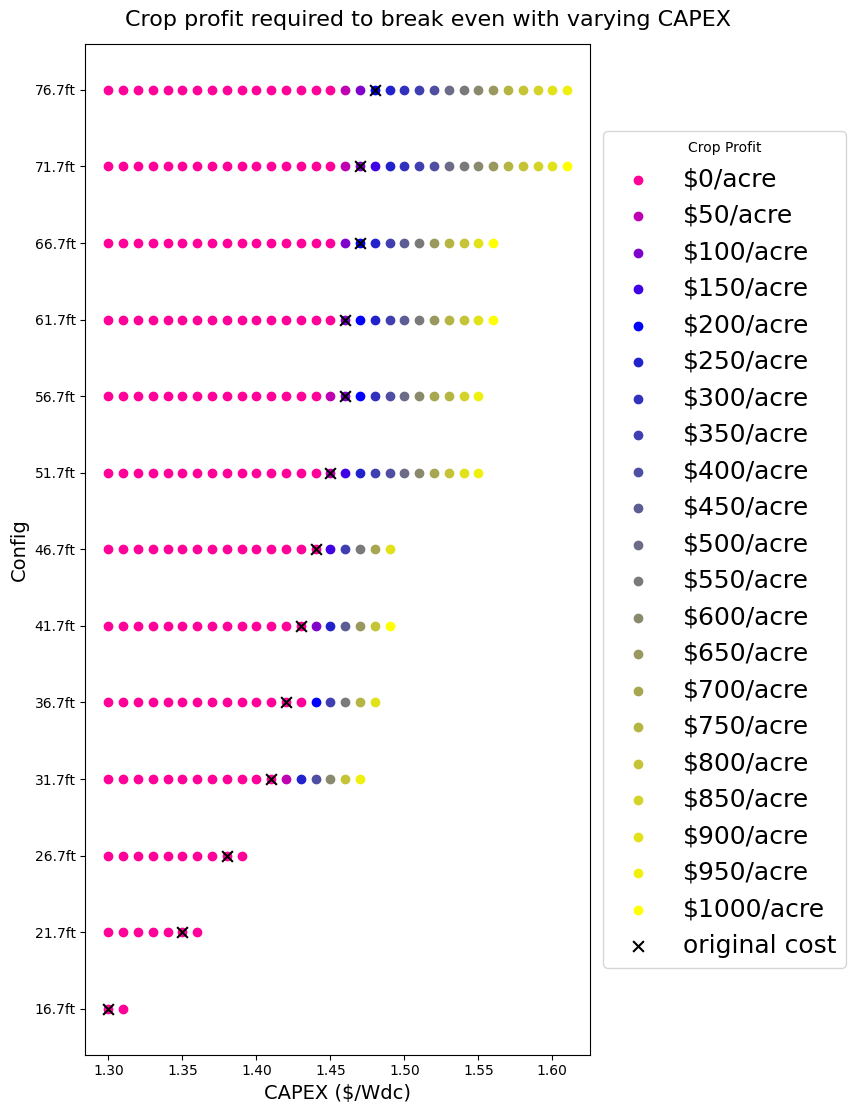

In [24]:
import matplotlib.colors

max_npv_df = pd.read_csv("breakeven_price_sweep_510.csv")

SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
        
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

acres = 160.0

max_profit_per_acre = 1000

dollars_per_watt_original = [
1.30, 
1.35, 
1.38,
1.41,
1.42,
1.43,
1.44,
1.45,
1.46,
1.46,
1.47,
1.47,
1.48]


#xtics = range(-1 * max_profit_per_acre, max_profit_per_acre, 200)
#xlabels = breakeven_lines.columns.get_level_values(1)[0::4] / 100.0

#ytics = range(0, 35, 5)
#ylabels = breakeven_lines.index.values[0::5]

fig = plt.figure(figsize=(8.5, 11))

color1 = "#FF0099"
color15 = "#0000FF"
color16 = "#2222CC"
color2 = "#FFFF00"

steep_grad = get_color_gradient(color1, color15, 5)
print(type(steep_grad))

shallow_grad = get_color_gradient(color16, color2, 16)

color_grad = []
color_grad.extend(steep_grad)
color_grad.extend(shallow_grad)

ax1 = fig.add_subplot(1, 1, 1)

ax1.set_ylabel('Config')
ax1.set_xlabel('CAPEX ($/Wdc)')

fig.suptitle('Crop profit required to break even with varying CAPEX', y=1)

crop_profits = range(0, 160001, 8000)

x = []
y = []
z = []
l = []
for i, profit in enumerate(crop_profits):
    cfg = max_npv_df.query('`Open Air Crop Profit` == @profit')
    price = cfg["$/W"].values
    config = cfg["Config"].values
    label_string = "$" + str(int(profit / 160)) + "/acre"
    ax1.scatter(price, config, color=color_grad[i], label=label_string)
"""
for i, config in enumerate(configs):
    for j, price in enumerate(price_sensitivity):
        cfg = max_npv_df.query('`Config` == @config and `$/W` == @price')
        if not cfg.empty:
            crop_profit = cfg["Open Air Crop Profit"].values[0]
            print(crop_profit, int(crop_profit / 160 / 20))
            x.append(price)
            y.append(i)
            z.append(color_grad[int(crop_profit / 160 / 50)])
            l.append("$" + str(int(crop_profit / 160)) + "/acre")
        else:
            print('empty!', price, config)

ax1.scatter(x, y, color=z)
"""
ax1.scatter(dollars_per_watt_original, configs, marker="x", color='black', label='original cost', s=60)

#ax1.set_xbound(-max_profit_per_acre, max_profit_per_acre)
ax1.set_yticks(range(0,13))
ax1.set_yticklabels(configs)
#ax1.set_xticks(xtics)


handles, labels = ax1.get_legend_handles_labels()
#ax1.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.03, 0.55), title="Row Spacing", fontsize = 18)
print(handles)

# Handles and labels from the above scatter have issues with repeated labels, hack in the color map from an above
ax1.legend(handles, labels, loc="center left",  bbox_to_anchor=(1, 0.5), title="Crop Profit", fontsize = 18)

fig.tight_layout(pad=0.5)
fig.savefig("crop_profit_by_capex.png")

In [7]:
price_comp_df = pd.read_csv("adams_co_price_comparison_2_config.csv")

crop_profits = set(price_comp_df["Open Air Crop Profit"])
crops = set(price_comp_df["Crop"])
config_subset = set(price_comp_df["Config"])
prices = set(price_comp_df["$/W"])
cfg = "16.7ft"
dfs = []
for price in prices:
    for cfg in config_subset:
        for cp in crop_profits:
            for crop in crops:
                df_c = price_comp_df.query('`Open Air Crop Profit` == @cp and NPV > 0 and Config == @cfg and Crop == @crop and `$/W` == @price')
                df_breakeven = df_c.iloc[(df_c["NPV"]).abs().argsort()][:1]
                dfs.append(df_breakeven)

breakeven_lines_price_comp = pd.concat(dfs)


In [36]:
breakeven_lines_price_comp.to_csv("breakeven_by_price_adams_co.csv")

[<matplotlib.collections.PathCollection object at 0x0000021BCDA2FC10>, <matplotlib.collections.PathCollection object at 0x0000021BCD934810>, <matplotlib.collections.PathCollection object at 0x0000021BC8B38E10>, <matplotlib.collections.PathCollection object at 0x0000021BCD934D50>, <matplotlib.collections.LineCollection object at 0x0000021BCDB79510>, <matplotlib.collections.LineCollection object at 0x0000021BCCD76B50>, <matplotlib.collections.LineCollection object at 0x0000021BCDB7B5D0>, <matplotlib.collections.LineCollection object at 0x0000021BCCEE2690>]


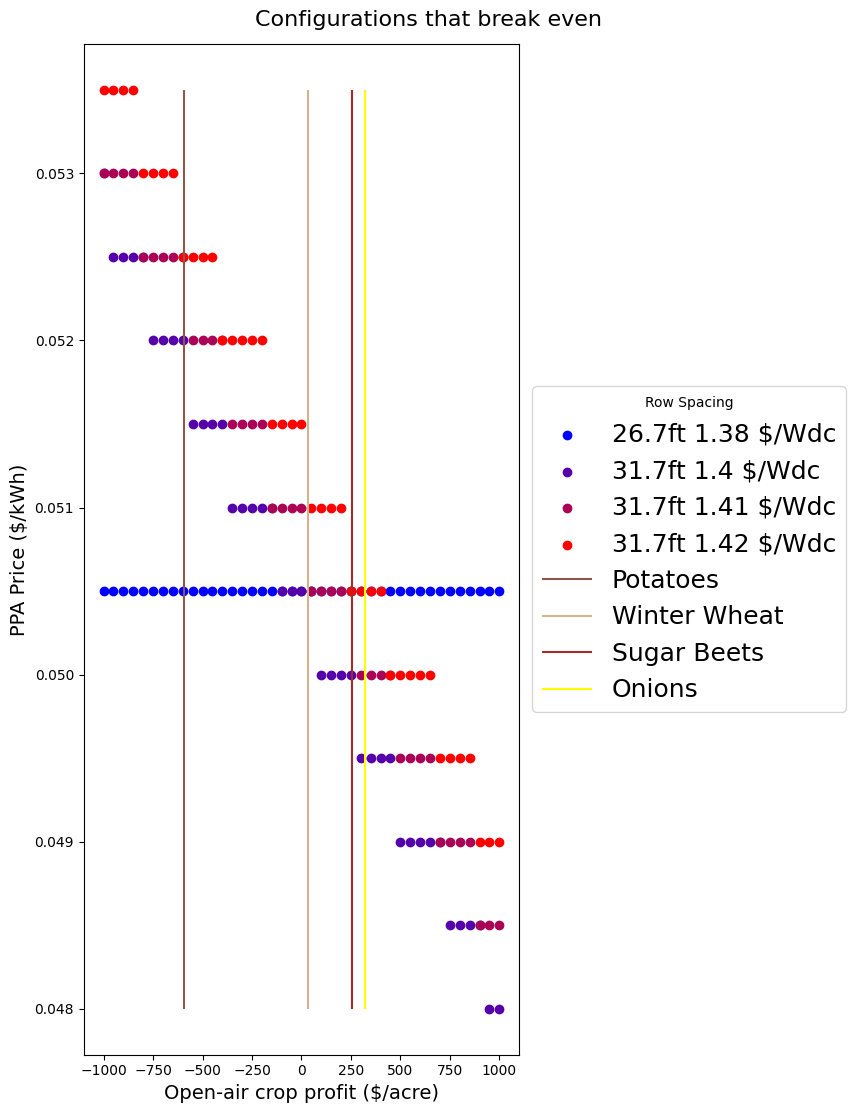

In [8]:
import matplotlib.colors

breakeven_lines_price_comp = pd.read_csv("breakeven_by_price_adams_co.csv")

SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
        
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

acres = 160.0

max_profit_per_acre = 1000

xtics = range(-1 * max_profit_per_acre, max_profit_per_acre, 200)
#xlabels = breakeven_lines.columns.get_level_values(1)[0::4] / 100.0

#ytics = range(0, 35, 5)
#ylabels = breakeven_lines.index.values[0::5]

fig = plt.figure(figsize=(8.5, 11))

color1 = "#0000FF"
color2 = "#FF0000"

config_list = ["26.7ft", "31.7ft","31.7ft","31.7ft"]
price_list = [1.38, 1.40, 1.41, 1.42]

color_grad = get_color_gradient(color1, color2, 4)

ax1 = fig.add_subplot(1, 1, 1)

ax1.set_ylabel('PPA Price ($/kWh)')
ax1.set_xlabel('Open-air crop profit ($/acre)')

fig.suptitle('Configurations that break even', y=1)

for i in range(0,4):
    cfg = config_list[i]
    price = price_list[i]
    lbl = cfg + " " + str(price) + " $/Wdc"
    cfg_line = breakeven_lines_price_comp.query('`Config` == @cfg and `$/W` == @price') 
    cfg_line = cfg_line.iloc[(-1.0*cfg_line["Open Air Crop Profit"]).argsort()[:]]
    ax1.scatter(cfg_line["Open Air Crop Profit"].values / acres, cfg_line["PPA price"].values, label=lbl, color=color_grad[i])

ax1.vlines(-595, 0.048, 0.0535, label="Potatoes", colors="tab:brown")
ax1.vlines(31, 0.048, 0.0535, label="Winter Wheat", colors="tan")
ax1.vlines(257, 0.048, 0.0535, label="Sugar Beets", colors="brown")
ax1.vlines(322, 0.048, 0.0535, label="Onions", colors="yellow")
#ax1.set_xbound(-max_profit_per_acre, max_profit_per_acre)
#ax1.set_ybound(0.04, 0.065)
#ax1.set_xticks(xtics)

handles, labels = ax1.get_legend_handles_labels()
#ax1.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.03, 0.55), title="Row Spacing", fontsize = 18)
print(handles)

# Handles and labels from the above scatter have issues with repeated labels, hack in the color map from an above
ax1.legend(handles, labels, loc="center left",  bbox_to_anchor=(1, 0.5), title="Row Spacing", fontsize = 18)

fig.tight_layout(pad=0.5)
fig.savefig("profitable_configurations.png")

    Row Spacing (ft)  System Size (kWdc)  Energy Yield  LCOE (nominal)     GCR
0               16.7               45426          1946            5.48  0.4490
1               21.7               34788          2015            5.46  0.3450
2               26.7               28172          2054            5.46  0.2800
3               31.7               23861          2078            5.47  0.2360
4               36.7               20408          2093            5.49  0.2040
5               41.7               18112          2099            5.51  0.1790
6               46.7               16097          2106            5.52  0.1600
7               51.7               14660          2111            5.53  0.1450
8               56.7               13223          2114            5.55  0.1320
9               61.7               12075          2119            5.55  0.1210
10              66.7               11199          2119            5.57  0.1120
11              71.7               10381          21

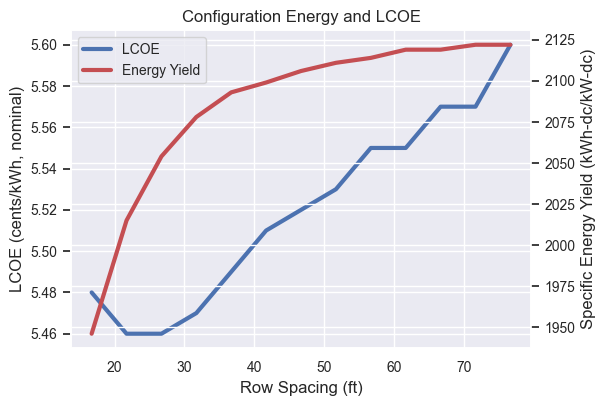

In [32]:
lcoe_data = pd.read_excel("LCOE for row spacing.xlsx")
print(lcoe_data)

fig = plt.figure(figsize=(6, 4))

ax1 = fig.add_subplot(111)

ax1.set_title('Configuration Energy and LCOE')
ax1.set_ylabel('LCOE (cents/kWh, nominal)')
ax1.set_xlabel('Row Spacing (ft)')

ax1.plot(lcoe_data['Row Spacing (ft)'], lcoe_data['LCOE (nominal)'], label="LCOE", color='b',  linewidth=3)

ax2 = ax1.twinx()

ax2.set_ylabel("Specific Energy Yield (kWh-dc/kW-dc)")
ax2.plot(lcoe_data['Row Spacing (ft)'], lcoe_data["Energy Yield"], label="Energy Yield", color='r',  linewidth=3)

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles1 + handles2, labels1 + labels2)

fig.tight_layout(pad=0.5)
fig.savefig("lcoe_curve.png")

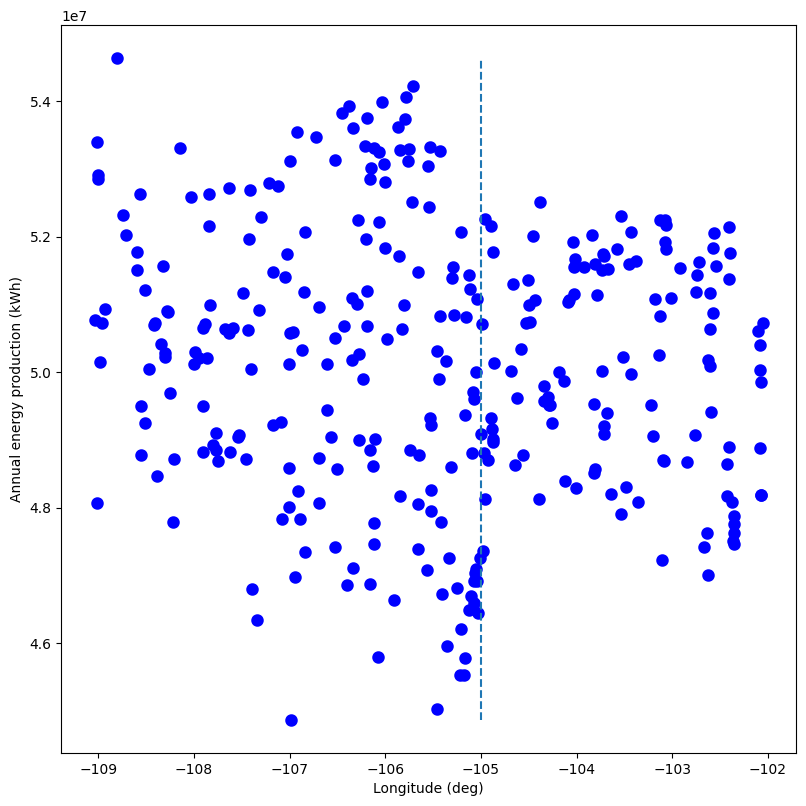

In [31]:
county_results_df = pd.read_csv("single_econ_multi_county_multi_point.csv")

fig = plt.figure(figsize=(8, 8))

ax1 = fig.add_subplot(111)

ax1.set_ylabel('Annual energy production (kWh)')
ax1.set_xlabel('Longitude (deg)')

ax1.scatter(county_results_df['Long'], county_results_df['Annual Energy Production (year 1)'], label="kWh", color='b',  linewidth=3)
ax1.vlines(-105.0, ymin=min(county_results_df['Annual Energy Production (year 1)']), ymax=max(county_results_df['Annual Energy Production (year 1)']), linestyle='dashed')

handles1, labels1 = ax1.get_legend_handles_labels()

fig.tight_layout(pad=0.5)
fig.savefig("aep_by_long.png")

In [32]:
county_results_df = county_results_df.rename(columns={"County" : "Point Name"})

county_names = county_results_df["Point Name"].str.split("-").str[0]
print(county_names)
county_results_df["County"] = county_names

0      ADAMS
1      ADAMS
2      ADAMS
3      ADAMS
4      ADAMS
       ...  
315     YUMA
316     YUMA
317     YUMA
318     YUMA
319     YUMA
Name: Point Name, Length: 320, dtype: object


In [33]:
print(county_results_df)

     Unnamed: 0 Point Name        Lat        Long  Config    Crop  \
0             0      ADAMS  39.873634 -104.337935  31.7ft  Onions   
1             0    ADAMS-N  39.993729 -104.263000  31.7ft  Onions   
2             0    ADAMS-E  39.884368 -103.719177  31.7ft  Onions   
3             0    ADAMS-S  39.749279 -104.282227  31.7ft  Onions   
4             0    ADAMS-W  39.878047 -105.043030  31.7ft  Onions   
..          ...        ...        ...         ...     ...     ...   
315           0       YUMA  40.002899 -102.424226  31.7ft  Onions   
316           0     YUMA-N  40.413463 -102.425537  31.7ft  Onions   
317           0     YUMA-E  39.783366 -102.084961  31.7ft  Onions   
318           0     YUMA-S  39.612241 -102.411804  31.7ft  Onions   
319           0     YUMA-W  39.991943 -102.763367  31.7ft  Onions   

     Solar capacity         CAPEX  PPA price  Open Air Crop Profit  \
0        23861.1177  3.443136e+07      0.051                 16000   
1        23861.1177  3.443136e+

In [42]:
counties = set(county_names)

dfs = []

for cnt in counties:
    df_c = county_results_df.query('`County` == @cnt')
    df_max_npv = df_c.nlargest(1, "NPV")
    dfs.append(df_max_npv)

max_county_profits = pd.concat(dfs)

max_county_profits.to_csv('max_county_profits.csv')